# **<span>Differentially Private Analysis of COMPAS Dataset</span>**

### Group Members:
 - Anthony Lewis
 - Lincoln Badejo
 - Loren Fang
 - Margil Funtanilla
 - Tom Tooma



In [241]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# read in raw recidivism dataset from Propublica GitHub repo for COMPAS analysis
df_raw = pd.read_csv('compas-scores-two-years.csv')

# Usable randomness for Data Privacy experiments
rng = np.random.default_rng(seed=42)

plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['axes.grid'] = True

print('Raw dataset shape:', df_raw.shape)
df_raw.head()

Raw dataset shape: (7214, 53)


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [242]:
df_raw.shape

(7214, 53)

# Preprocess

Build the two-year recidivism dataset based on filtering, using rules found in ProPublica GitHub repo

In [243]:
# Rule 1. Keep only rows where the arrest is within 30 days of screening
df = df_raw[(df_raw["days_b_screening_arrest"] >= -30) &
        (df_raw["days_b_screening_arrest"] <= 30)]

# Rule 2. Drop cases with indeterminate recidivism label
df = df[df["is_recid"] != -1]

# Rule 3. Drop ordinary traffic offenses since they won't result in jail time
df = df[df["c_charge_degree"] != "O"]

# Rule 4. Improvised to keep only rows that have a valid two-year outcome, which
# in the ProPublica code dealt with this by how the two_year_recid is
# constructed. This is already encoded as `two_year_recid`.
df = df.dropna(subset = ["two_year_recid"])
df["two_year_recid"] = df["two_year_recid"].astype(int)

In [244]:
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1


In [245]:
# number of rows and collumns
df.shape

(6172, 53)

In [246]:
# statistical properties for numeric data types
df.describe()

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,1997.000000,0.0,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000,6172.000000
mean,5509.259883,34.534511,0.059300,4.418503,0.091218,0.110661,3.246436,-1.740279,24.903273,0.484446,20.100651,NaN,0.112119,4.418503,3.641769,3.246436,13.316753,555.049417,0.389825,0.455120
std,3171.878516,11.730938,0.463599,2.839463,0.497872,0.470731,4.743770,5.084709,276.812982,0.499799,76.543499,NaN,0.315539,2.839463,2.488768,4.743770,50.138185,400.258400,0.487750,0.498022
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-30.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2753.750000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.000000,0.000000,0.000000
50%,5521.000000,31.000000,0.000000,4.000000,0.000000,0.000000,1.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,1.000000,0.000000,539.500000,0.000000,0.000000
75%,8225.250000,42.000000,0.000000,7.000000,0.000000,0.000000,4.000000,-1.000000,1.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,4.000000,3.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,9.000000,38.000000,30.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000


In [247]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

In [248]:
# capitalize variables for easier distinction from collumn variables and code
# variables
# PII columns
PII_COLS = [
    "name", # full name
    "first", # first name
    "last", # last name
    "id"
]

# These are indirect identifiers (indir) that can re-identify when combined
# with another field
INDIR_COLS = [
    "age",
    "age_cat", # already bucketed, so its low risk
    "compas_screening_date", "screening_date", "v_screening_date",
    "juv_fel_count", "juv_misd_count", "juv_other_count",
    "priors_count", "priors_count.1",
    "days_b_screening_arrest", "c_days_from_compas", "r_days_from_arrest"
]

# SPII columns (sensitive PII)
SPII_COLS = [
    "dob",  # date of birth
    "race", "sex",
    "c_case_number", "r_case_number", "vr_case_number",
    "c_charge_desc", "r_charge_desc", "vr_charge_desc",
    "c_charge_degree", "r_charge_degree", "vr_charge_degree",
    "c_offense_date", "c_arrest_date",
    "r_offense_date", "r_arrest_date", "vr_offense_date",
    "c_jail_in", "c_jail_out", "r_jail_in", "r_jail_out",
    "is_recid", "violent_recid", "is_violent_recid", "two_year_recid",
    "in_custody", "out_custody",
    "type_of_assessment", "v_type_of_assessment",
    "decile_score", "decile_score.1", "v_decile_score",
    "score_text", "v_score_text",
    "event"
]

# Keep only columns that exist in df (defensive)
pii_cols_present = [c for c in PII_COLS if c in df.columns]
indir_cols_present = [c for c in INDIR_COLS if c in df.columns]
spii_cols_present = [c for c in SPII_COLS if c in df.columns]

# Create PII, INDIR, and SPII subsets
pii_df = df[pii_cols_present].copy()
indir_df = df[indir_cols_present].copy()
spii_df = df[spii_cols_present].copy()

# Combining subsets PII, INDIR, and SPII
pii_spii_cols = sorted(set(pii_cols_present + indir_cols_present + spii_cols_present))
pii_spii_df = df[pii_spii_cols].copy()

# Checks shapes
# Note: start and end columns fit neither PII, INDIR, or SPII definitions
print("PII shape:", pii_df.shape)
print("INDIR shape:", indir_df.shape)
print("SPII shape:", spii_df.shape)
print("Combined PII, INDIR, and SPII shape:", pii_spii_df.shape)

PII shape: (6172, 4)
INDIR shape: (6172, 13)
SPII shape: (6172, 34)
Combined PII, INDIR, and SPII shape: (6172, 51)


# DP Test

In [249]:
def laplace_mechanism(value, sensitivity, epsilon):
    noise = np.random.laplace(0, sensitivity/epsilon)
    return value + noise

def gaussian_mechanism(value, sensitivity, epsilon, delta):
    sigma = np.sqrt(2 * np.log(1.25/delta)) * sensitivity / epsilon
    noise = np.random.normal(0, sigma)
    return value + noise

epsilons = [1, 0.5, 0.1, 0.01]
delta = 1e-5

# List of queries performed on the dataset

## Query 1: Distribution of racial groups in the dataset

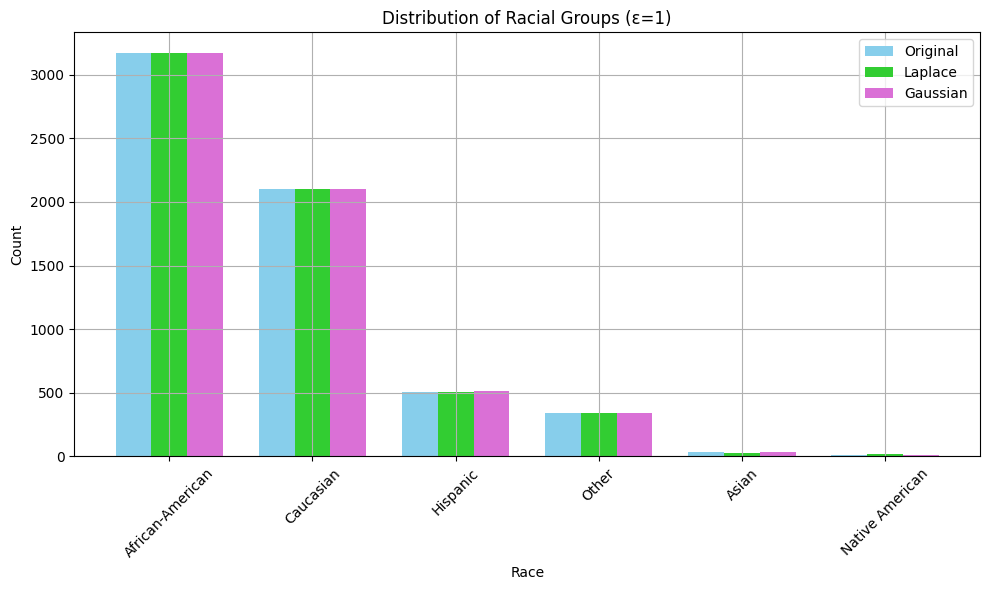

Race Distribution with ε = 1
                  Original  Laplace (ε=1)  Gaussian (ε=1)
race                                                     
African-American      3175         3174.5          3169.2
Caucasian             2103         2102.5          2100.5
Hispanic               509          509.1           514.8
Other                  343          343.0           338.6
Asian                   31           29.5            36.4
Native American         11           15.4            11.8


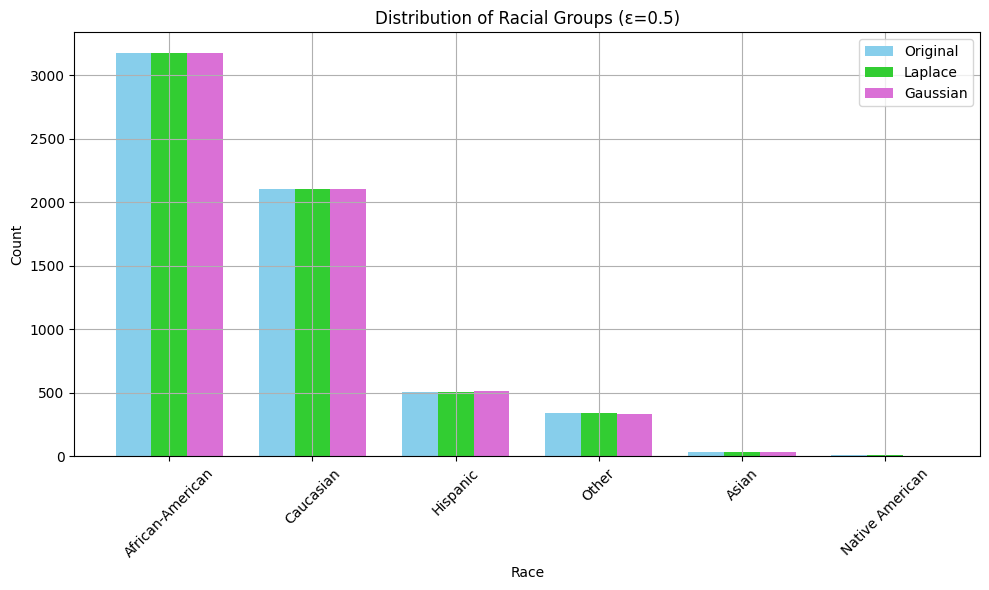

Race Distribution with ε = 0.5
                  Original  Laplace (ε=0.5)  Gaussian (ε=0.5)
race                                                         
African-American      3175           3179.4            3177.6
Caucasian             2103           2107.5            2103.9
Hispanic               509            508.6             515.6
Other                  343            341.0             334.4
Asian                   31             33.8              32.1
Native American         11             11.2               5.6


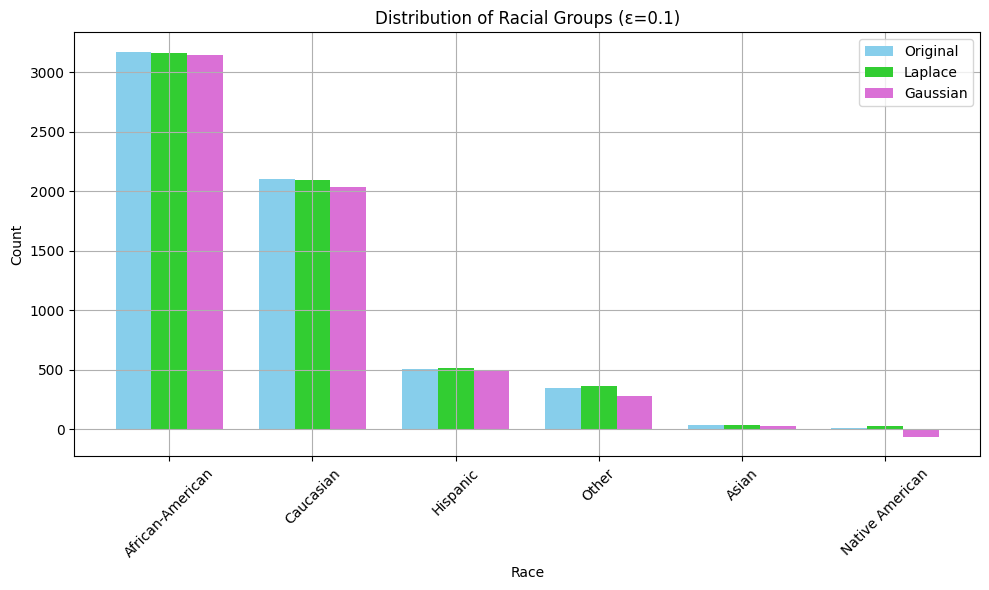

Race Distribution with ε = 0.1
                  Original  Laplace (ε=0.1)  Gaussian (ε=0.1)
race                                                         
African-American      3175           3166.2            3142.5
Asian                   31             38.6             -66.9
Caucasian             2103           2099.4            2033.5
Hispanic               509            511.8             493.3
Native American         11             24.4              29.4
Other                  343            359.1             278.9


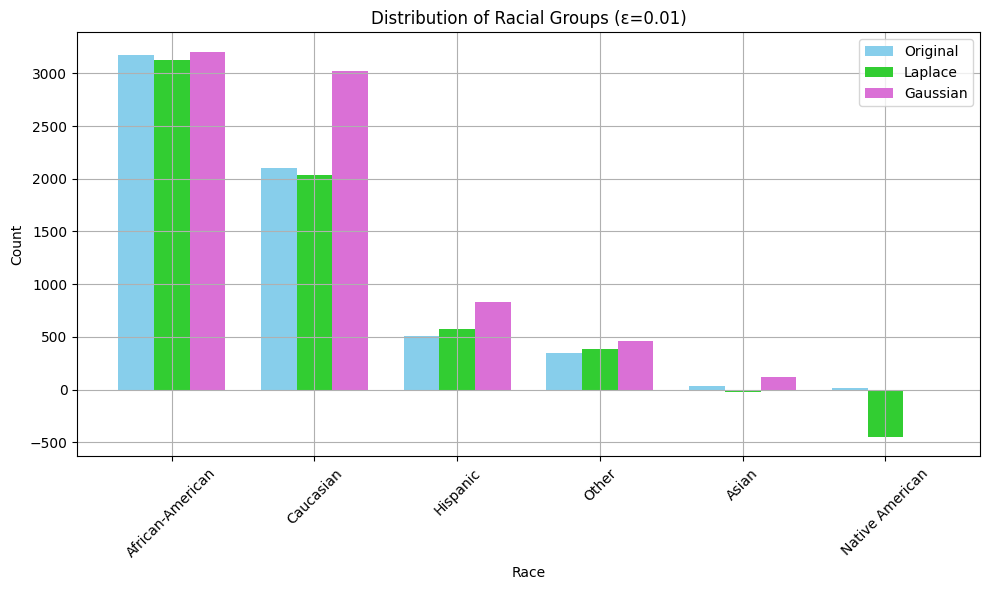

Race Distribution with ε = 0.01
                  Original  Laplace (ε=0.01)  Gaussian (ε=0.01)
race                                                           
African-American      3175            3124.7             3019.9
Asian                   31            -450.7              119.4
Caucasian             2103            2031.5             3206.0
Hispanic               509             575.8              826.3
Native American         11             -22.6              463.8
Other                  343             386.8                1.0


In [250]:
sensitivity_count = 1

race_counts = df['race'].value_counts().sort_values(ascending=False)
races = race_counts.index
bar_width = 0.25
x = np.arange(len(races))

for epsilon in epsilons:
    laplace_race_counts = race_counts.apply(lambda count: laplace_mechanism(count, sensitivity_count, epsilon)).sort_values(ascending=False)
    gaussian_race_counts = race_counts.apply(lambda count: gaussian_mechanism(count, sensitivity_count, epsilon, delta)).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width, race_counts.values, width=bar_width, label='Original', color='skyblue')
    plt.bar(x, laplace_race_counts.values, width=bar_width, label='Laplace', color='limegreen')
    plt.bar(x + bar_width, gaussian_race_counts.values, width=bar_width, label='Gaussian', color='orchid')
    plt.xticks(x, races, rotation=45)
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.title(f'Distribution of Racial Groups (ε={epsilon})')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Comparison table
    import pandas as pd
    comparison = pd.DataFrame({
        'Original': race_counts,
        f'Laplace (ε={epsilon})': laplace_race_counts,
        f'Gaussian (ε={epsilon})': gaussian_race_counts
    })
    print(f"Race Distribution with ε = {epsilon}")
    print(comparison.round(1))

## Query 2: Distribution of age in the dataset

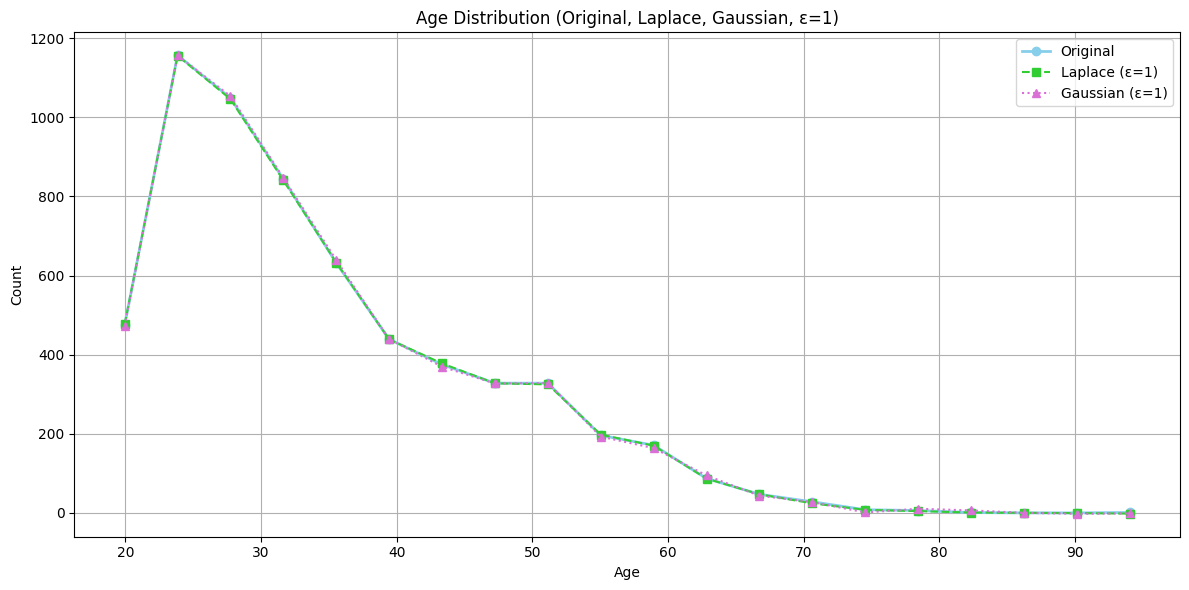

Age Histogram Bin Comparison (ε=1):
      Original  Laplace (ε=1)  Gaussian (ε=1)
20.0       475          476.4           472.5
23.8      1157         1155.9          1156.4
27.8      1049         1046.2          1053.8
31.6       844          840.8           847.1
35.6       632          632.7           639.3
39.4       439          438.6           439.5
43.3       375          377.8           369.6
47.2       328          327.5           327.2
51.2       328          325.0           328.4
55.0       196          197.9           192.8
59.0       171          170.0           163.8
62.8        87           86.6            94.6
66.8        47           47.0            43.4
70.6        28           24.1            27.3
74.6         8            7.6             1.1
78.4         6            4.6            10.5
82.4         1            0.9             6.3
86.2         0            0.1             0.2
90.2         0           -0.5            -2.3
94.0         1           -1.8            -1.

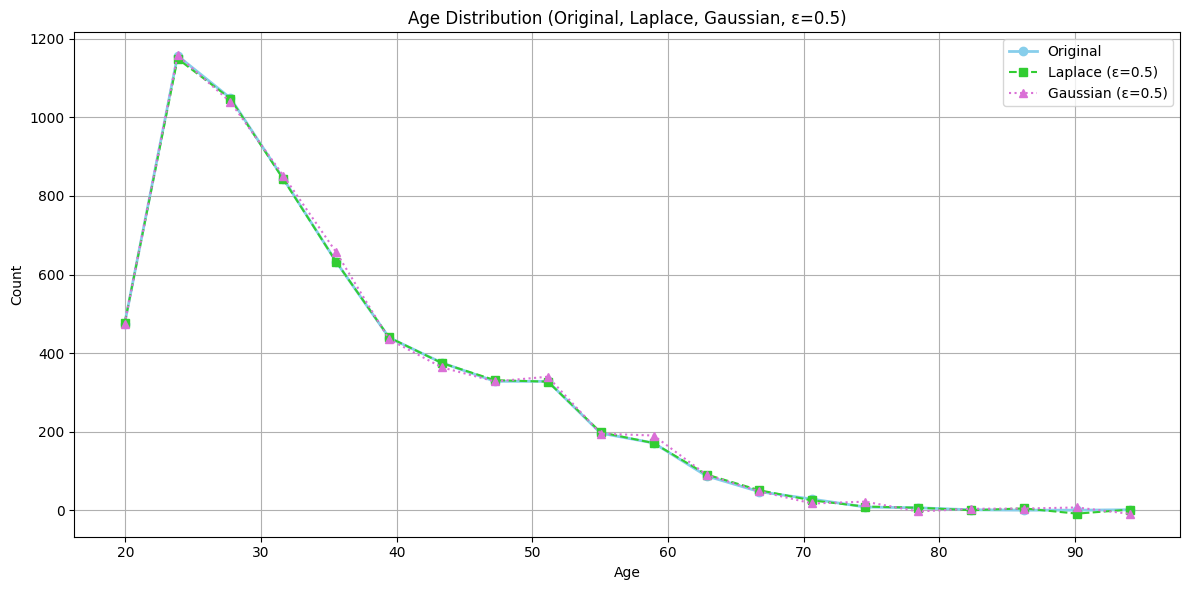

Age Histogram Bin Comparison (ε=0.5):
      Original  Laplace (ε=0.5)  Gaussian (ε=0.5)
20.0       475            475.7             474.2
23.8      1157           1149.5            1158.3
27.8      1049           1047.7            1039.2
31.6       844            842.4             851.8
35.6       632            631.9             656.4
39.4       439            439.7             434.9
43.3       375            374.4             363.4
47.2       328            331.0             327.7
51.2       328            327.1             339.8
55.0       196            198.2             194.7
59.0       171            170.8             190.1
62.8        87             90.7              90.0
66.8        47             50.7              48.0
70.6        28             24.7              17.0
74.6         8              9.1              21.7
78.4         6              6.2              -3.3
82.4         1             -0.1               3.4
86.2         0              4.5               4.1
90.2        

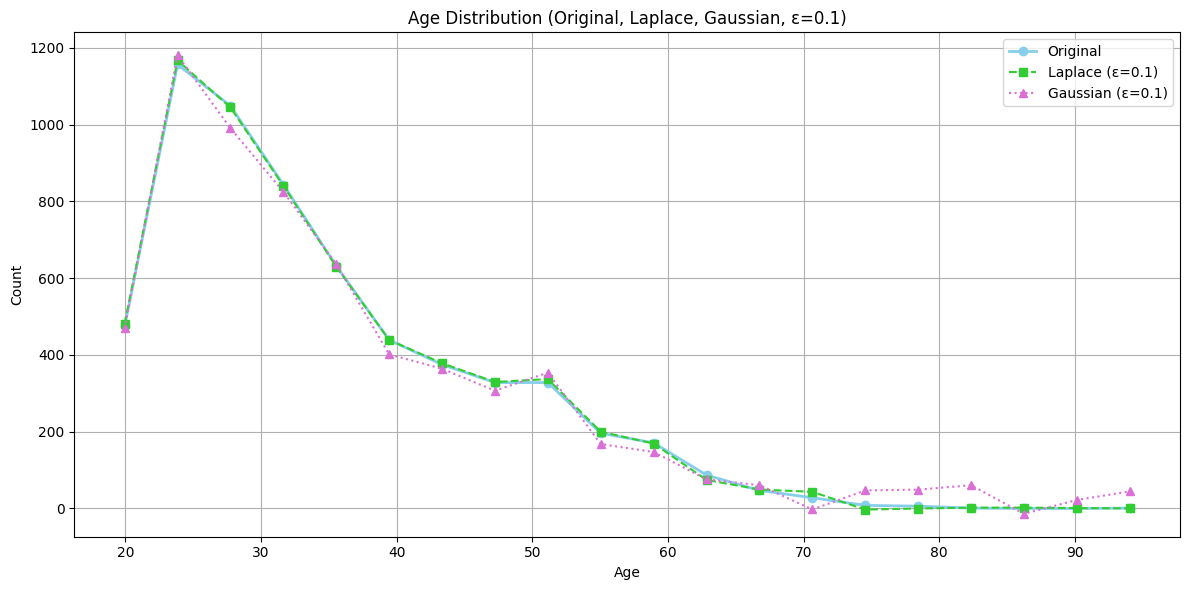

Age Histogram Bin Comparison (ε=0.1):
      Original  Laplace (ε=0.1)  Gaussian (ε=0.1)
20.0       475            481.5             469.6
23.8      1157           1167.6            1180.9
27.8      1049           1044.8             990.8
31.6       844            840.7             825.3
35.6       632            630.0             636.7
39.4       439            439.2             401.6
43.3       375            378.4             364.0
47.2       328            329.5             306.9
51.2       328            337.2             354.0
55.0       196            200.0             167.8
59.0       171            169.1             147.2
62.8        87             74.4              75.7
66.8        47             49.3              60.7
70.6        28             43.4              -2.7
74.6         8             -2.9              47.0
78.4         6             -0.1              49.1
82.4         1              2.0              60.6
86.2         0              2.2             -13.9
90.2        

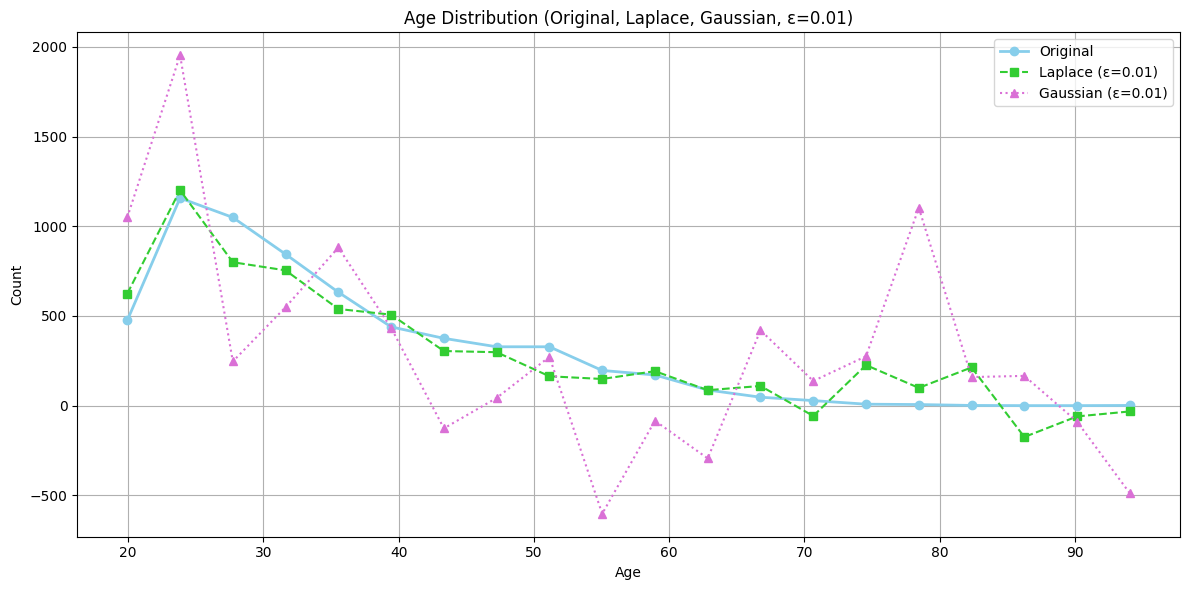

Age Histogram Bin Comparison (ε=0.01):
      Original  Laplace (ε=0.01)  Gaussian (ε=0.01)
20.0       475             624.2             1049.1
23.8      1157            1201.0             1952.9
27.8      1049             799.3              246.2
31.6       844             753.9              548.9
35.6       632             538.7              881.5
39.4       439             507.1              433.5
43.3       375             304.3             -126.9
47.2       328             297.8               42.8
51.2       328             163.5              272.0
55.0       196             148.6             -602.9
59.0       171             192.0              -84.2
62.8        87              86.1             -294.3
66.8        47             109.6              420.0
70.6        28             -57.5              137.3
74.6         8             225.9              275.0
78.4         6              98.9             1102.4
82.4         1             213.0              159.2
86.2         0           

In [251]:
sensitivity_count = 1

age_bins = np.linspace(df['age'].min(), df['age'].max(), 21)
hist_data, _ = np.histogram(df['age'], bins=age_bins)
x_centers = (age_bins[:-1] + age_bins[1:]) / 2

for epsilon in epsilons:
    laplace_hist_data = [laplace_mechanism(count, sensitivity_count, epsilon) for count in hist_data]
    gaussian_hist_data = [gaussian_mechanism(count, sensitivity_count, epsilon, delta) for count in hist_data]

    plt.figure(figsize=(12, 6))
    plt.plot(x_centers, hist_data, marker='o', label='Original', color='skyblue', linewidth=2)
    plt.plot(x_centers, laplace_hist_data, marker='s', label=f'Laplace (ε={epsilon})', color='limegreen', linestyle='--')
    plt.plot(x_centers, gaussian_hist_data, marker='^', label=f'Gaussian (ε={epsilon})', color='orchid', linestyle=':')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title(f'Age Distribution (Original, Laplace, Gaussian, ε={epsilon})')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Comparison table
    import pandas as pd
    comparison_df = pd.DataFrame({
        'Original': hist_data,
        f'Laplace (ε={epsilon})': laplace_hist_data,
        f'Gaussian (ε={epsilon})': gaussian_hist_data
    }, index=np.round(x_centers, 1))
    print(f"Age Histogram Bin Comparison (ε={epsilon}):")
    print(comparison_df.round(1))

## Query 3: Distribution of gender in the dataset

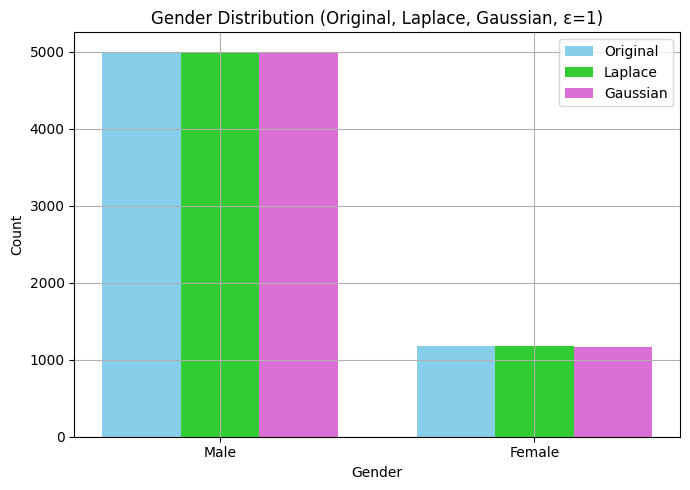

Gender Distribution with ε = 1
        Original  Laplace (ε=1)  Gaussian (ε=1)
sex                                            
Male        4997         4999.3          5005.1
Female      1175         1176.1          1169.1


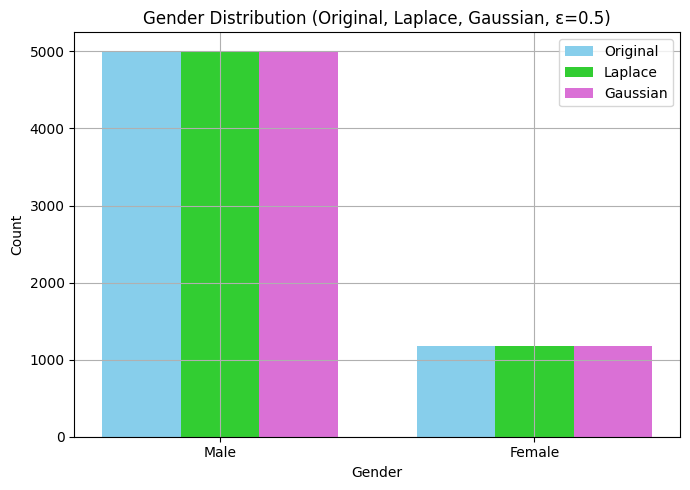

Gender Distribution with ε = 0.5
        Original  Laplace (ε=0.5)  Gaussian (ε=0.5)
sex                                                
Male        4997           4994.0            4997.4
Female      1175           1178.0            1178.5


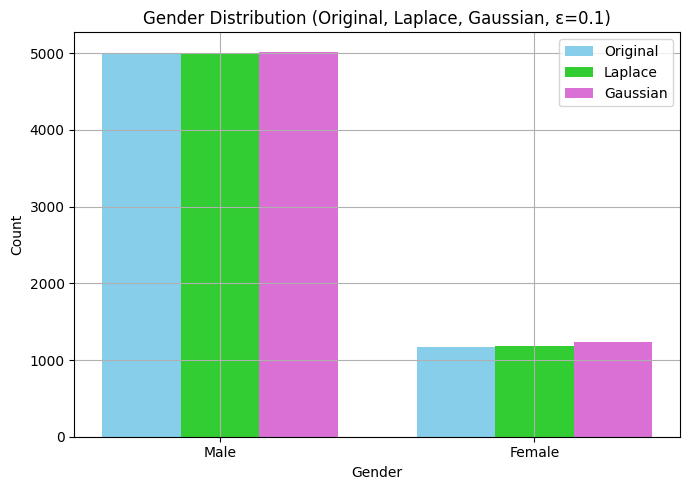

Gender Distribution with ε = 0.1
        Original  Laplace (ε=0.1)  Gaussian (ε=0.1)
sex                                                
Male        4997           5000.7            5020.9
Female      1175           1182.9            1229.7


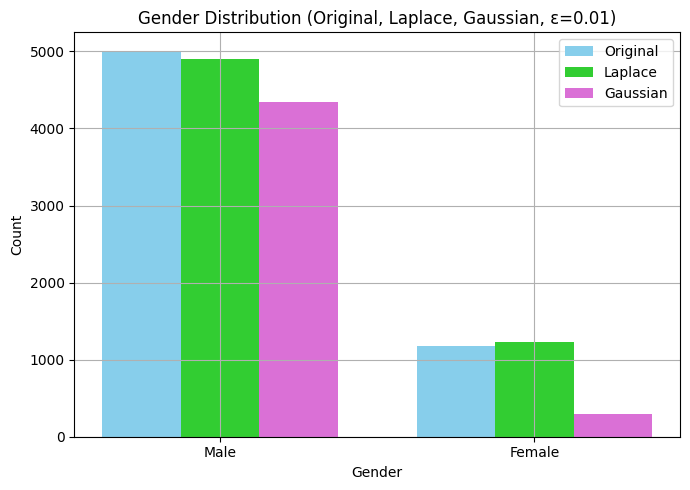

Gender Distribution with ε = 0.01
        Original  Laplace (ε=0.01)  Gaussian (ε=0.01)
sex                                                  
Male        4997            4896.8             4339.5
Female      1175            1230.7              292.3


In [252]:
sensitivity_count = 1

gender_counts = df['sex'].value_counts()
genders = gender_counts.index
bar_width = 0.25
x = np.arange(len(genders))

for epsilon in epsilons:
    laplace_gender_counts = gender_counts.apply(lambda x: laplace_mechanism(x, sensitivity_count, epsilon))
    gaussian_gender_counts = gender_counts.apply(lambda x: gaussian_mechanism(x, sensitivity_count, epsilon, delta))

    plt.figure(figsize=(7, 5))
    plt.bar(x - bar_width, gender_counts.values, width=bar_width, label='Original', color='skyblue')
    plt.bar(x, laplace_gender_counts.values, width=bar_width, label='Laplace', color='limegreen')
    plt.bar(x + bar_width, gaussian_gender_counts.values, width=bar_width, label='Gaussian', color='orchid')
    plt.xticks(x, genders)
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.title(f'Gender Distribution (Original, Laplace, Gaussian, ε={epsilon})')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Comparison table
    import pandas as pd
    comparison = pd.DataFrame({
        'Original': gender_counts,
        f'Laplace (ε={epsilon})': laplace_gender_counts,
        f'Gaussian (ε={epsilon})': gaussian_gender_counts
    })
    print(f"Gender Distribution with ε = {epsilon}")
    print(comparison.round(1))

## Query 4: Average COMPAS score for the defendants


Epsilon = 1
Original mean COMPAS score: 4.42
Laplace noisy mean: 4.42
Gaussian noisy mean: 4.42


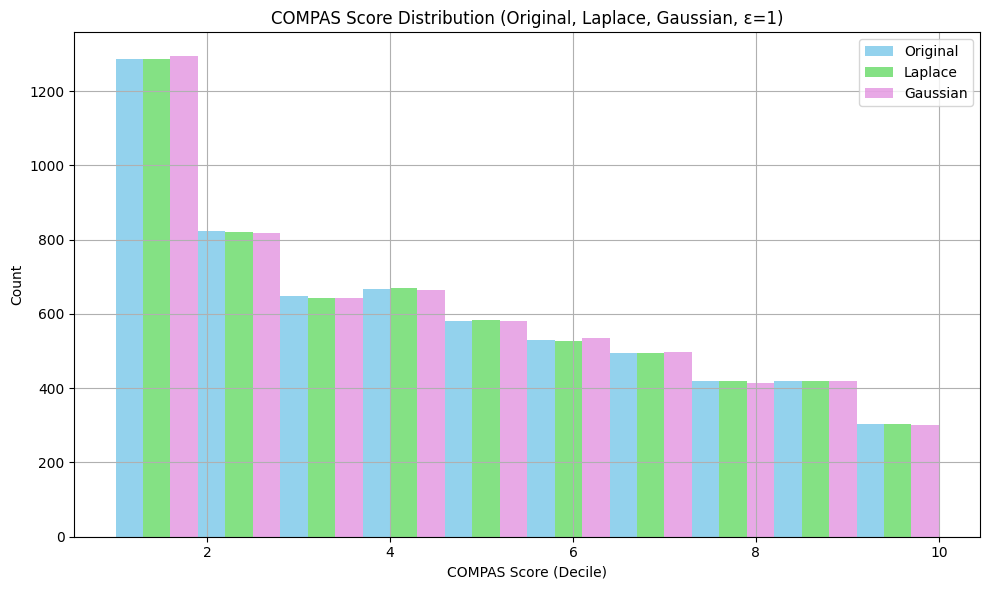

COMPAS Score Histogram Bin Comparison (ε=1):
     Original  Laplace (ε=1)  Gaussian (ε=1)
1.4      1286         1286.6          1293.5
2.3       822          821.1           817.1
3.2       647          643.4           643.4
4.2       666          668.8           663.8
5.0       582          582.2           581.8
6.0       529          528.3           535.6
6.8       496          496.0           497.2
7.8       420          420.0           413.3
8.6       420          420.3           419.6
9.6       304          304.7           301.8

Epsilon = 0.5
Original mean COMPAS score: 4.42
Laplace noisy mean: 4.42
Gaussian noisy mean: 4.42


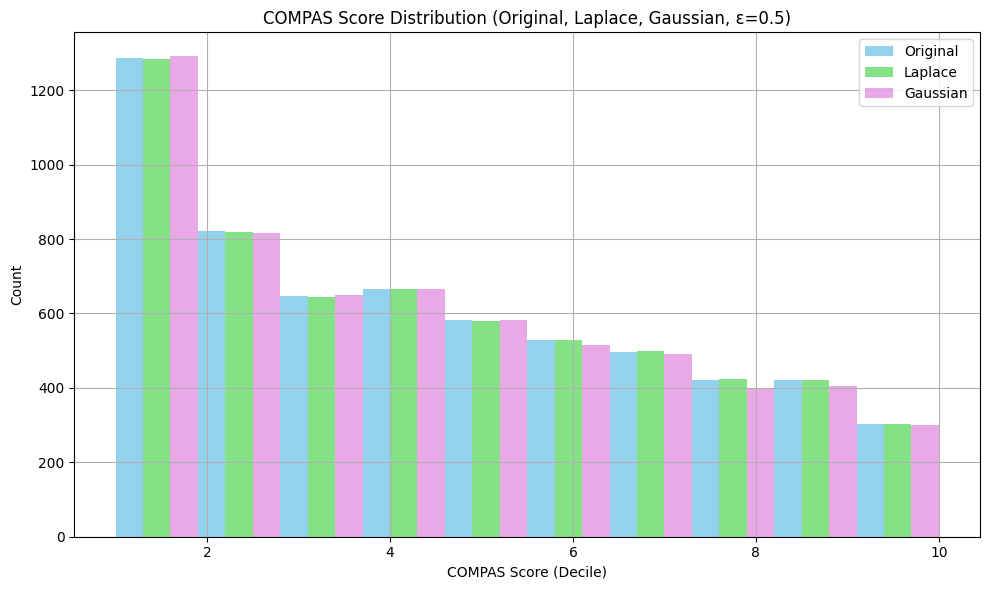

COMPAS Score Histogram Bin Comparison (ε=0.5):
     Original  Laplace (ε=0.5)  Gaussian (ε=0.5)
1.4      1286           1285.4            1291.2
2.3       822            820.2             817.1
3.2       647            644.0             649.7
4.2       666            665.4             665.9
5.0       582            580.3             582.7
6.0       529            527.7             516.3
6.8       496            498.8             491.3
7.8       420            424.5             397.8
8.6       420            421.1             405.1
9.6       304            304.0             299.0

Epsilon = 0.1
Original mean COMPAS score: 4.42
Laplace noisy mean: 4.43
Gaussian noisy mean: 4.33


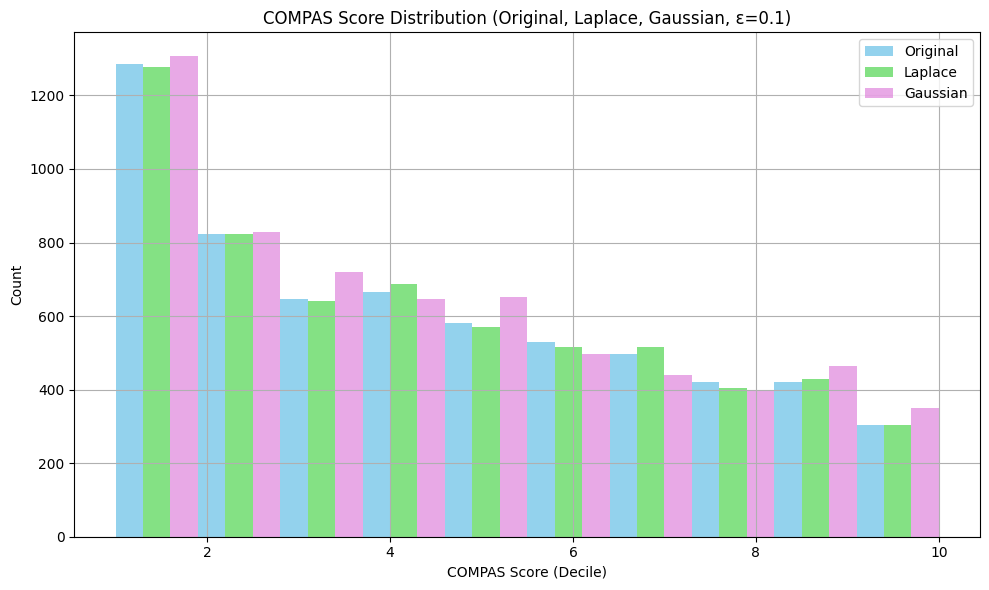

COMPAS Score Histogram Bin Comparison (ε=0.1):
     Original  Laplace (ε=0.1)  Gaussian (ε=0.1)
1.4      1286           1276.7            1306.3
2.3       822            822.7             828.2
3.2       647            640.8             721.2
4.2       666            687.5             646.1
5.0       582            571.0             651.2
6.0       529            516.3             496.2
6.8       496            514.7             438.5
7.8       420            405.2             395.1
8.6       420            429.4             464.2
9.6       304            303.2             349.2

Epsilon = 0.01
Original mean COMPAS score: 4.42
Laplace noisy mean: 4.39
Gaussian noisy mean: 4.64


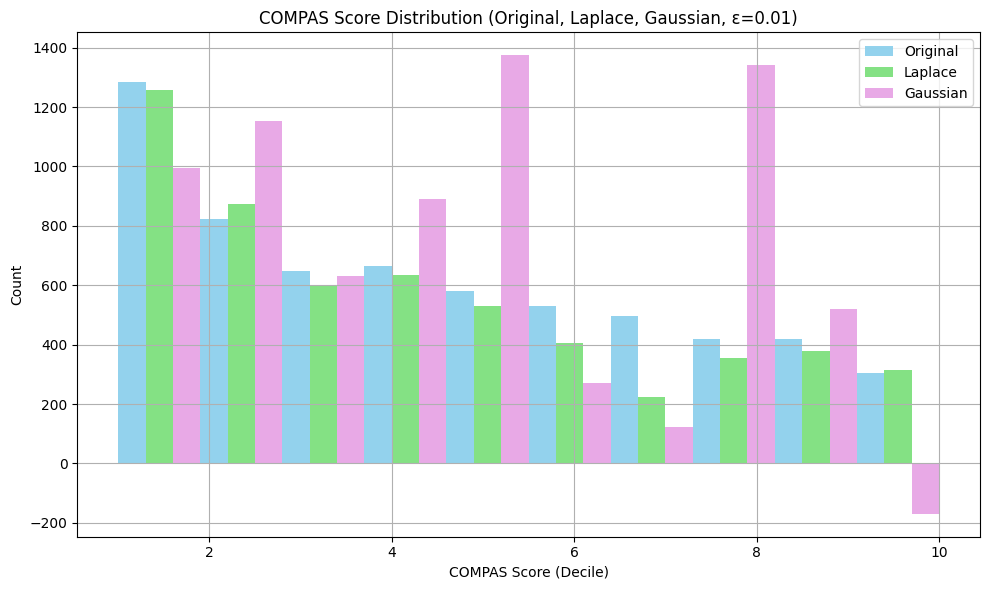

COMPAS Score Histogram Bin Comparison (ε=0.01):
     Original  Laplace (ε=0.01)  Gaussian (ε=0.01)
1.4      1286            1257.9              994.9
2.3       822             872.7             1151.7
3.2       647             601.8              629.9
4.2       666             634.9              891.6
5.0       582             531.3             1374.5
6.0       529             404.5              272.4
6.8       496             223.3              123.4
7.8       420             354.1             1343.4
8.6       420             378.0              521.4
9.6       304             314.7             -169.5


In [253]:
score_min = df['decile_score'].min()
score_max = df['decile_score'].max()
n = len(df)
sensitivity_count = 1   # For histogram bins
sensitivity_mean = (score_max - score_min) / n

true_mean = df['decile_score'].mean()

score_hist, score_bins = np.histogram(df['decile_score'], bins=10, range=(score_min, score_max))
x_centers = (score_bins[:-1] + score_bins[1:]) / 2

for epsilon in epsilons:
    laplace_mean = laplace_mechanism(true_mean, sensitivity_mean, epsilon)
    gaussian_mean = gaussian_mechanism(true_mean, sensitivity_mean, epsilon, delta)
    print(f"\nEpsilon = {epsilon}")
    print(f"Original mean COMPAS score: {true_mean:.2f}")
    print(f"Laplace noisy mean: {laplace_mean:.2f}")
    print(f"Gaussian noisy mean: {gaussian_mean:.2f}")

    laplace_score_hist = [laplace_mechanism(count, sensitivity_count, epsilon) for count in score_hist]
    gaussian_score_hist = [gaussian_mechanism(count, sensitivity_count, epsilon, delta) for count in score_hist]

    plt.figure(figsize=(10, 6))
    plt.bar(x_centers - 0.3, score_hist, width=0.3, label='Original', color='skyblue', alpha=0.9)
    plt.bar(x_centers, laplace_score_hist, width=0.3, label='Laplace', color='limegreen', alpha=0.6)
    plt.bar(x_centers + 0.3, gaussian_score_hist, width=0.3, label='Gaussian', color='orchid', alpha=0.6)
    plt.xlabel('COMPAS Score (Decile)')
    plt.ylabel('Count')
    plt.title(f'COMPAS Score Distribution (Original, Laplace, Gaussian, ε={epsilon})')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Comparison table
    import pandas as pd
    comp_hist_df = pd.DataFrame({
        'Original': score_hist,
        f'Laplace (ε={epsilon})': laplace_score_hist,
        f'Gaussian (ε={epsilon})': gaussian_score_hist
    }, index=np.round(x_centers, 1))
    print(f"COMPAS Score Histogram Bin Comparison (ε={epsilon}):")
    print(comp_hist_df.round(1))

## Query 5: Proportion of defendants who committed a new crime over next 2 years


Epsilon = 1
Original recidivism rate: 45.51%
Laplace noisy recidivism rate: 45.47%
Gaussian noisy recidivism rate: 45.39%


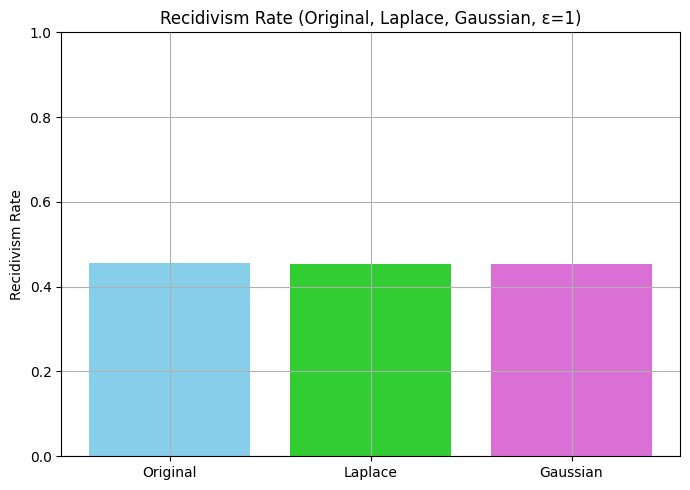


Epsilon = 0.5
Original recidivism rate: 45.51%
Laplace noisy recidivism rate: 45.50%
Gaussian noisy recidivism rate: 45.55%


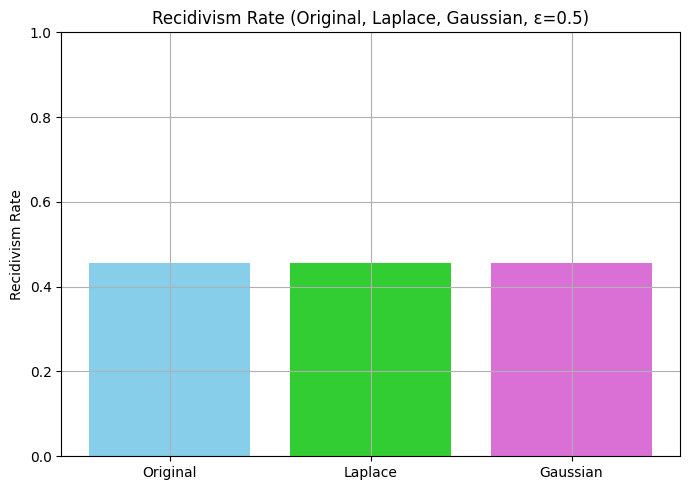


Epsilon = 0.1
Original recidivism rate: 45.51%
Laplace noisy recidivism rate: 45.28%
Gaussian noisy recidivism rate: 46.24%


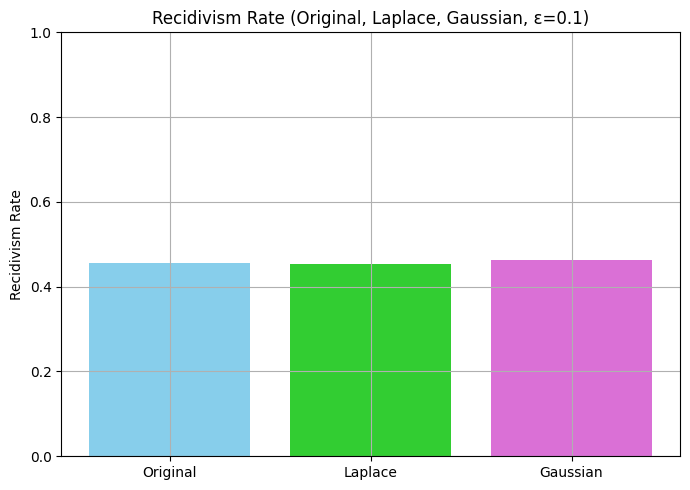


Epsilon = 0.01
Original recidivism rate: 45.51%
Laplace noisy recidivism rate: 44.53%
Gaussian noisy recidivism rate: 49.24%


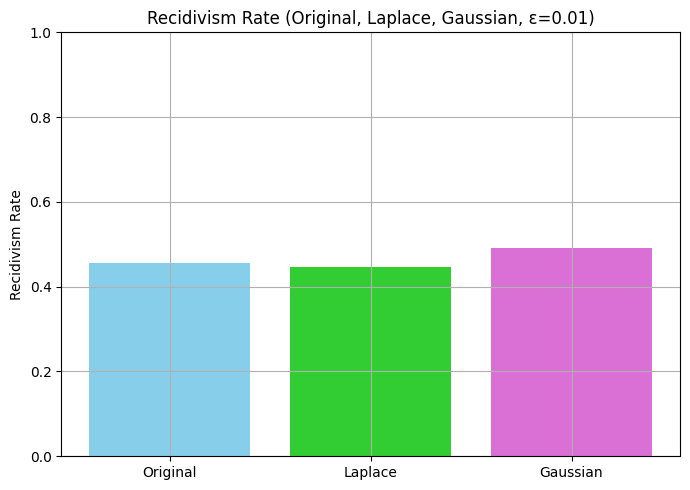

In [254]:
recidivated = df['two_year_recid'].sum()
total = len(df)
recidivism_rate = recidivated / total
sensitivity_prop = 1 / total  # For proportions/averages

for epsilon in epsilons:
    laplace_recidivism_rate = laplace_mechanism(recidivism_rate, sensitivity_prop, epsilon)
    gaussian_recidivism_rate = gaussian_mechanism(recidivism_rate, sensitivity_prop, epsilon, delta)

    print(f"\nEpsilon = {epsilon}")
    print(f"Original recidivism rate: {recidivism_rate:.2%}")
    print(f"Laplace noisy recidivism rate: {laplace_recidivism_rate:.2%}")
    print(f"Gaussian noisy recidivism rate: {gaussian_recidivism_rate:.2%}")

    rates = [recidivism_rate, laplace_recidivism_rate, gaussian_recidivism_rate]
    labels = ['Original', 'Laplace', 'Gaussian']
    colors = ['skyblue', 'limegreen', 'orchid']

    plt.figure(figsize=(7, 5))
    plt.bar(labels, rates, color=colors)
    plt.ylabel('Recidivism Rate')
    plt.ylim(0, 1)
    plt.title(f'Recidivism Rate (Original, Laplace, Gaussian, ε={epsilon})')
    plt.tight_layout()
    plt.show()

## Query 6: Diff in avg COMPAS score: Black - White defendants


Epsilon = 1
Original diff (Black - White): 1.64
Laplace noisy diff: 1.64
Gaussian noisy diff: 1.65


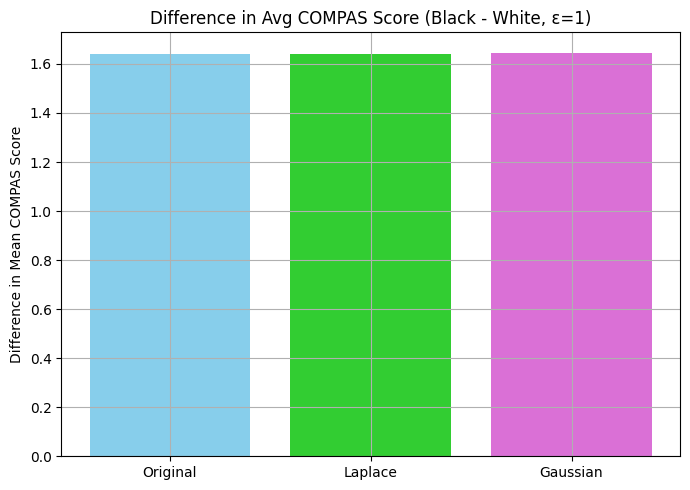


Epsilon = 0.5
Original diff (Black - White): 1.64
Laplace noisy diff: 1.64
Gaussian noisy diff: 1.62


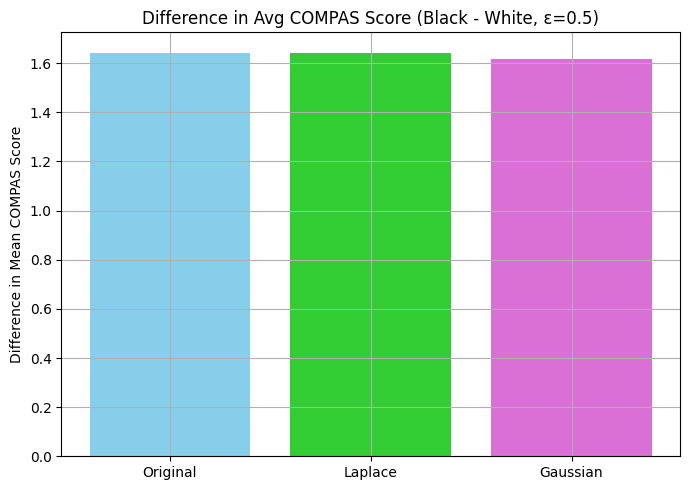


Epsilon = 0.1
Original diff (Black - White): 1.64
Laplace noisy diff: 1.62
Gaussian noisy diff: 1.69


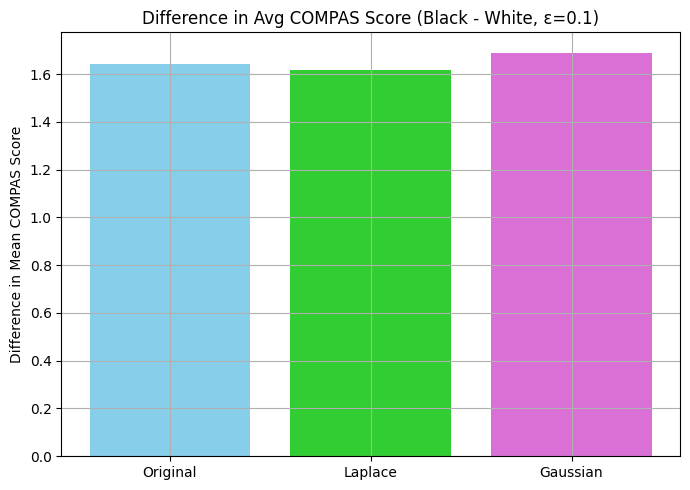


Epsilon = 0.01
Original diff (Black - White): 1.64
Laplace noisy diff: 1.89
Gaussian noisy diff: -0.45


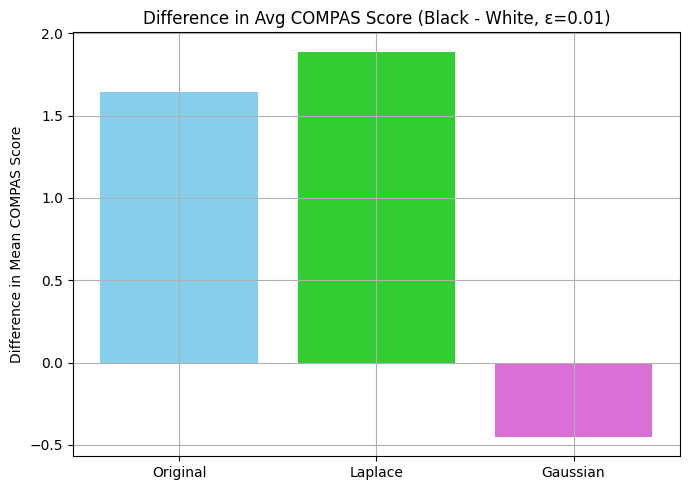

In [255]:
score_min = df['decile_score'].min()
score_max = df['decile_score'].max()
n = len(df)
sensitivity_diff = (score_max - score_min) / n * 2

black_mean = df[df['race'] == 'African-American']['decile_score'].mean()
white_mean = df[df['race'] == 'Caucasian']['decile_score'].mean()
true_diff = black_mean - white_mean

for epsilon in epsilons:
    laplace_diff = laplace_mechanism(true_diff, sensitivity_diff, epsilon)
    gaussian_diff = gaussian_mechanism(true_diff, sensitivity_diff, epsilon, delta)

    print(f"\nEpsilon = {epsilon}")
    print(f"Original diff (Black - White): {true_diff:.2f}")
    print(f"Laplace noisy diff: {laplace_diff:.2f}")
    print(f"Gaussian noisy diff: {gaussian_diff:.2f}")

    diffs = [true_diff, laplace_diff, gaussian_diff]
    labels = ['Original', 'Laplace', 'Gaussian']
    colors = ['skyblue', 'limegreen', 'orchid']

    plt.figure(figsize=(7, 5))
    plt.bar(labels, diffs, color=colors)
    plt.ylabel('Difference in Mean COMPAS Score')
    plt.title(f'Difference in Avg COMPAS Score (Black - White, ε={epsilon})')
    plt.tight_layout()
    plt.show()

## Now let's evaluate two additional queries focused on the DecileScores:
- Race distribution of `DecileScore` (counts)
- Mean `DecileScore` by two-year recidivism outcome

Each query is evaluated under:
- Non-DP (ground truth)
- Laplace DP
- Gaussian DP

All analysis is restricted to the **three most common races**, and before each plot we print the underlying table of raw or DP values used to generate that figure.

In [256]:
# Keep only columns needed
df = df[['decile_score', 'race', 'sex', 'two_year_recid']].copy()
df = df.rename(columns={
    'decile_score': 'DecileScore',
    'race': 'Race',
    'sex': 'Sex',
    'two_year_recid': 'OutcomeTwoYearRecid'
})

# Clean types and normalize race labels
df['DecileScore'] = pd.to_numeric(df['DecileScore'], errors='coerce')
df['Race'] = df['Race'].astype(str).str.strip().replace({'African-Am': 'African-American'})
df['Sex'] = df['Sex'].astype(str).str.strip()

df = df.dropna()

top3_races = df['Race'].value_counts().head(3).index.tolist()
df_top3 = df[df['Race'].isin(top3_races)].copy()

print('Final preprocessed shape (top 3 races):', df_top3.shape)
print('Top 3 races:', top3_races)

Final preprocessed shape (top 3 races): (5787, 4)
Top 3 races: ['African-American', 'Caucasian', 'Hispanic']


In [257]:
SCORE_MIN = 1
SCORE_MAX = 10
SCORE_RANGE = SCORE_MAX - SCORE_MIN

In [258]:
def table_decile_distribution_by_race(data, sex_label, races):
    #Return counts table of DecileScore x Race for a given sex subset
    subset = data[(data['Sex'] == sex_label) & (data['Race'].isin(races))]
    counts = subset.groupby(['DecileScore', 'Race']).size().reset_index(name='count')
    return counts


def plot_decile_distribution_by_race_from_table(counts, sex_label, races):
    deciles = list(range(1, 11))
    matrix = []
    for d in deciles:
        row = []
        for r in races:
            sub = counts[(counts['DecileScore'] == d) & (counts['Race'] == r)]
            row.append(sub['count'].iloc[0] if not sub.empty else 0)
        matrix.append(row)

    matrix = np.array(matrix)
    x = np.arange(len(deciles))
    width = 0.8 / len(races)

    plt.figure()
    for i, r in enumerate(races):
        plt.bar(x + (i - (len(races)-1)/2)*width, matrix[:, i], width, label=r)

    plt.xticks(x, deciles)
    plt.xlabel('DecileScore')
    plt.ylabel('Number of Individuals')
    plt.title(f'DecileScore Distribution by Race for {sex_label}s (Non-DP)')
    plt.legend(title='Race')
    plt.tight_layout()
    plt.show()

def table_mean_decile_by_outcome_and_race(data, sex_label, races):
    subset = data[(data['Sex'] == sex_label) & (data['Race'].isin(races))]
    means = subset.groupby(['OutcomeTwoYearRecid', 'Race'])['DecileScore']\
                   .mean().reset_index().rename(columns={'DecileScore': 'mean_decilescore'})
    return means

def plot_mean_decile_by_outcome_and_race_from_table(means, sex_label, races):
    outcomes = [0, 1]
    matrix = []
    for o in outcomes:
        row = []
        for r in races:
            sub = means[(means['OutcomeTwoYearRecid'] == o) & (means['Race'] == r)]
            row.append(sub['mean_decilescore'].iloc[0] if not sub.empty else np.nan)
        matrix.append(row)

    matrix = np.array(matrix)
    x = np.arange(len(outcomes))
    width = 0.8 / len(races)

    plt.figure()
    for i, r in enumerate(races):
        plt.bar(x + (i - (len(races)-1)/2)*width, matrix[:, i], width, label=r)

    plt.xticks(x, outcomes)
    plt.xlabel('OutcomeTwoYearRecid (0 = No, 1 = Yes)')
    plt.ylabel('Mean DecileScore')
    plt.title(f'Mean DecileScore by Outcome for {sex_label}s (Non-DP)')
    plt.legend(title='Race')
    plt.tight_layout()
    plt.show()

# Query 7: Non-DP DecileScore Distribution by Race

### 7.1 Male – Raw Counts Table and Plot

    DecileScore              Race  count
0             1  African-American    288
1             1         Caucasian    468
2             1          Hispanic    137
3             2  African-American    266
4             2         Caucasian    257
5             2          Hispanic     69
6             3  African-American    237
7             3         Caucasian    182
8             3          Hispanic     55
9             4  African-American    278
10            4         Caucasian    202
11            4          Hispanic     32
12            5  African-American    254
13            5         Caucasian    148
14            5          Hispanic     37
15            6  African-American    263
16            6         Caucasian    107
17            6          Hispanic     24
18            7  African-American    293
19            7         Caucasian     84
20            7          Hispanic     27
21            8  African-American    263
22            8         Caucasian     78
23            8 

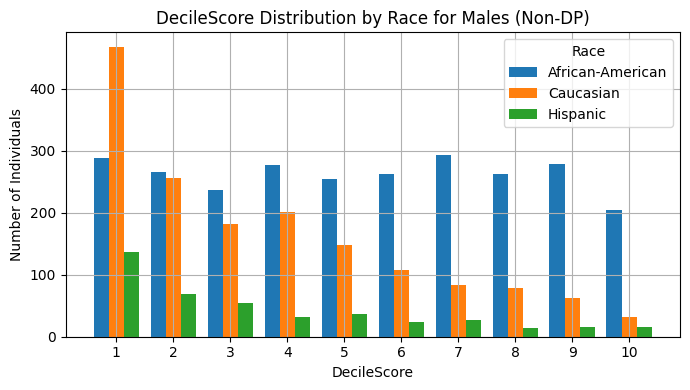

In [259]:
male_counts = table_decile_distribution_by_race(df_top3, 'Male', top3_races)
print(male_counts)
plot_decile_distribution_by_race_from_table(male_counts, 'Male', top3_races)

### 7.2 Female – Raw Counts Table and Plot

    DecileScore              Race  count
0             1  African-American     77
1             1         Caucasian    137
2             1          Hispanic     22
3             2  African-American     80
4             2         Caucasian     64
5             2          Hispanic     20
6             3  African-American     61
7             3         Caucasian     56
8             3          Hispanic     18
9             4  African-American     59
10            4         Caucasian     41
11            4          Hispanic     15
12            5  African-American     69
13            5         Caucasian     52
14            5          Hispanic      2
15            6  African-American     55
16            6         Caucasian     53
17            6          Hispanic      3
18            7  African-American     50
19            7         Caucasian     29
20            7          Hispanic      1
21            8  African-American     38
22            8         Caucasian     18
23            9 

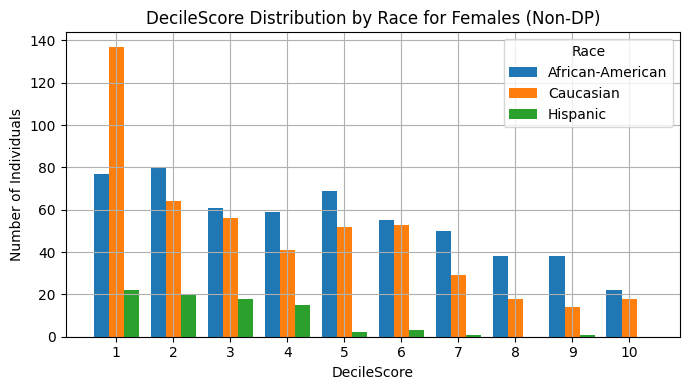

In [260]:
female_counts = table_decile_distribution_by_race(df_top3, 'Female', top3_races)
print(female_counts)
plot_decile_distribution_by_race_from_table(female_counts, 'Female', top3_races)

# Differential Privacy Mechanisms Helper Functions

In [261]:
epsilon = 1.0
delta = 1e-5

def dp_count_laplace(true_count, epsilon, rng):
    return max(0, true_count + rng.laplace(0, 1/epsilon))

def dp_count_gaussian(true_count, epsilon, delta, rng):
    sigma = np.sqrt(2 * np.log(1.25 / delta)) / epsilon
    return max(0, true_count + rng.normal(0, sigma))

def dp_mean_laplace(true_mean, n, epsilon, rng):
    if n == 0:
        return np.nan
    scale = SCORE_RANGE / (n * epsilon)
    return true_mean + rng.laplace(0, scale)

def dp_mean_gaussian(true_mean, n, epsilon, delta, rng):
    if n == 0:
        return np.nan
    sigma = (SCORE_RANGE / n) * np.sqrt(2 * np.log(1.25 / delta)) / epsilon
    return true_mean + rng.normal(0, sigma)

In [262]:
def table_dp_decile_distribution_by_race(data, sex_label, races, mechanism='laplace', epsilon=1.0, delta=1e-5, seed=123):
    #Return DP counts table of DecileScore x Race for a given sex subset
    subset = data[(data['Sex'] == sex_label) & (data['Race'].isin(races))]
    true_counts = subset.groupby(['DecileScore', 'Race']).size().reset_index(name='true_count')

    rng = np.random.default_rng(seed)
    dp_rows = []
    
    deciles = list(range(1, 11))
    for d in deciles:
        for r in races:
            sub = true_counts[(true_counts['DecileScore'] == d) & (true_counts['Race'] == r)]
            true_c = int(sub['true_count'].iloc[0]) if not sub.empty else 0
            if mechanism == 'laplace':
                dp_c = dp_count_laplace(true_c, epsilon, rng)
            else:
                dp_c = dp_count_gaussian(true_c, epsilon, delta, rng)
            dp_rows.append({'DecileScore': d, 'Race': r, 'true_count': true_c, 'dp_count': dp_c})

    dp_df = pd.DataFrame(dp_rows)
    return dp_df


def plot_dp_decile_distribution_by_race_from_table(dp_df, sex_label, races, mechanism_label):
    deciles = list(range(1, 11))
    matrix = []
    for d in deciles:
        row = []
        for r in races:
            sub = dp_df[(dp_df['DecileScore'] == d) & (dp_df['Race'] == r)]
            row.append(sub['dp_count'].iloc[0] if not sub.empty else 0)
        matrix.append(row)

    matrix = np.array(matrix)
    x = np.arange(len(deciles))
    width = 0.8 / len(races)

    plt.figure()
    for i, r in enumerate(races):
        plt.bar(x + (i - (len(races)-1)/2)*width, matrix[:, i], width, label=r)

    plt.xticks(x, deciles)
    plt.xlabel('DecileScore')
    plt.ylabel('DP Count')
    plt.title(f'{mechanism_label} DP DecileScore Distribution by Race for {sex_label}s')
    plt.legend(title='Race')
    plt.tight_layout()
    plt.show()


def table_dp_mean_decile_by_outcome_and_race(data, sex_label, races, mechanism='laplace', epsilon=1.0, delta=1e-5, seed=456):
    subset = data[(data['Sex'] == sex_label) & (data['Race'].isin(races))]
    grouped = subset.groupby(['OutcomeTwoYearRecid', 'Race'])['DecileScore']
    stats = grouped.agg(['mean', 'count']).reset_index()

    rng = np.random.default_rng(seed)
    dp_rows = []
    for _, row in stats.iterrows():
        true_m = row['mean']
        n = int(row['count'])
        if mechanism == 'laplace':
            dp_m = dp_mean_laplace(true_m, n, epsilon, rng)
        else:
            dp_m = dp_mean_gaussian(true_m, n, epsilon, delta, rng)
        dp_rows.append({
            'OutcomeTwoYearRecid': int(row['OutcomeTwoYearRecid']),
            'Race': row['Race'],
            'true_mean': true_m,
            'n': n,
            'dp_mean': dp_m,
        })

    dp_df = pd.DataFrame(dp_rows)
    return dp_df

def plot_dp_mean_decile_by_outcome_and_race_from_table(dp_df, sex_label, races, mechanism_label):
    outcomes = [0, 1]
    matrix = []
    for o in outcomes:
        row = []
        for r in races:
            sub = dp_df[(dp_df['OutcomeTwoYearRecid'] == o) & (dp_df['Race'] == r)]
            row.append(sub['dp_mean'].iloc[0] if not sub.empty else np.nan)
        matrix.append(row)

    matrix = np.array(matrix)
    x = np.arange(len(outcomes))
    width = 0.8 / len(races)

    plt.figure()
    for i, r in enumerate(races):
        plt.bar(x + (i - (len(races)-1)/2)*width, matrix[:, i], width, label=r)

    plt.xticks(x, outcomes)
    plt.xlabel('OutcomeTwoYearRecid (0 = No, 1 = Yes)')
    plt.ylabel('DP Mean DecileScore')
    plt.title(f'{mechanism_label} DP Mean DecileScore by Outcome for {sex_label}s')
    plt.legend(title='Race')
    plt.tight_layout()
    plt.show()

# Query 8: (DP) DecileScore Distribution by Race

### Laplace DP – Male

    DecileScore              Race  true_count    dp_count
0             1  African-American         288  289.108551
1             1         Caucasian         468  468.214566
2             1          Hispanic         137  136.451345
3             2  African-American         266  263.545465
4             2         Caucasian         257  259.943307
5             2          Hispanic          69   69.214361
6             3  African-American         237  237.868755
7             3         Caucasian         182  183.718576
8             3          Hispanic          55   55.472100
9             4  African-American         278  277.032371
10            4         Caucasian         202  205.295702
11            4          Hispanic          32   31.436969
12            5  African-American         254  254.299143
13            5         Caucasian         148  148.176824
14            5          Hispanic          37   37.222924
15            6  African-American         263  263.073104
16            

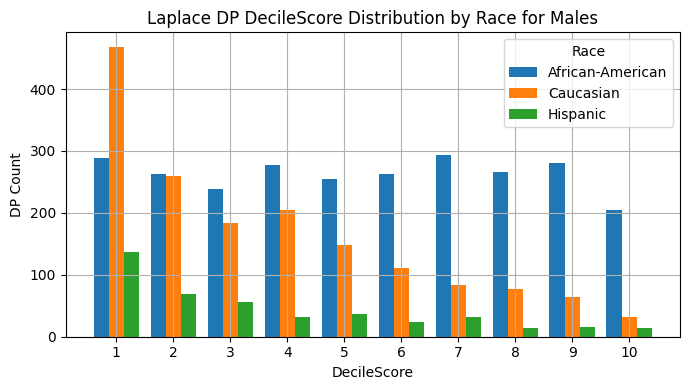

In [263]:
male_dp_lap = table_dp_decile_distribution_by_race(df_top3, 'Male', top3_races,mechanism='laplace', epsilon=epsilon, delta=delta, seed=100)
print(male_dp_lap)
plot_dp_decile_distribution_by_race_from_table(male_dp_lap, 'Male', top3_races, mechanism_label='Laplace')

## Query 9: DP Histogram of Scores by Race & Sex

We now build differentially private histograms of `DecileScore` by (race, sex)
using both Laplace and Gaussian mechanisms, and present the results with
easy-to-understand visual representations.

    DecileScore              Race  true_count    dp_count
0             1  African-American          77   79.180943
1             1         Caucasian         137  136.669886
2             1          Hispanic          22   22.843065
3             2  African-American          80   80.201573
4             2         Caucasian          64   63.470089
5             2          Hispanic          20   21.867246
6             3  African-American          61   62.341945
7             3         Caucasian          56   55.682926
8             3          Hispanic          18   20.925341
9             4  African-American          59   58.199376
10            4         Caucasian          41   41.944155
11            4          Hispanic          15   15.449092
12            5  African-American          69   68.940378
13            5         Caucasian          52   49.213084
14            5          Hispanic           2    3.558728
15            6  African-American          55   55.159307
16            

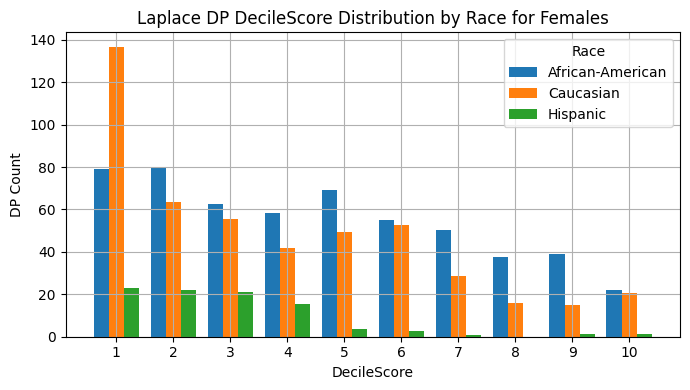

In [264]:
female_dp_lap = table_dp_decile_distribution_by_race(df_top3, 'Female', top3_races,mechanism='laplace', epsilon=epsilon, delta=delta, seed=101)
print(female_dp_lap)
plot_dp_decile_distribution_by_race_from_table(female_dp_lap, 'Female', top3_races, mechanism_label='Laplace')

### Laplace DP – Female

    DecileScore              Race  true_count    dp_count
0             1  African-American          77   79.180943
1             1         Caucasian         137  136.669886
2             1          Hispanic          22   22.843065
3             2  African-American          80   80.201573
4             2         Caucasian          64   63.470089
5             2          Hispanic          20   21.867246
6             3  African-American          61   62.341945
7             3         Caucasian          56   55.682926
8             3          Hispanic          18   20.925341
9             4  African-American          59   58.199376
10            4         Caucasian          41   41.944155
11            4          Hispanic          15   15.449092
12            5  African-American          69   68.940378
13            5         Caucasian          52   49.213084
14            5          Hispanic           2    3.558728
15            6  African-American          55   55.159307
16            

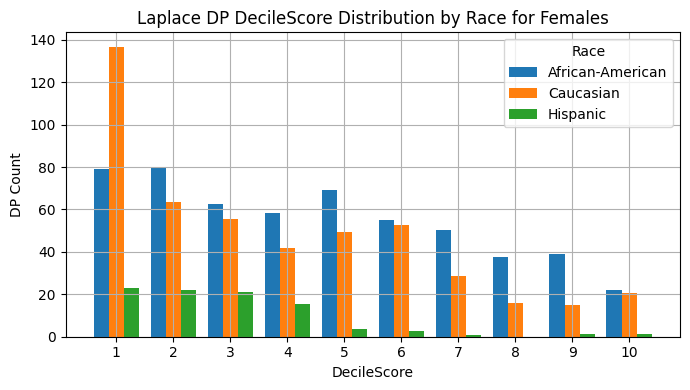

In [265]:
female_dp_lap = table_dp_decile_distribution_by_race(df_top3, 'Female', top3_races,mechanism='laplace', epsilon=epsilon, delta=delta, seed=101)
print(female_dp_lap)
plot_dp_decile_distribution_by_race_from_table(female_dp_lap, 'Female', top3_races, mechanism_label='Laplace')

### Gaussian DP – Male

    DecileScore              Race  true_count    dp_count
0             1  African-American         288  289.522660
1             1         Caucasian         468  465.926834
2             1          Hispanic         137  134.550360
3             2  African-American         266  267.353140
4             2         Caucasian         257  261.912328
5             2          Hispanic          69   70.839685
6             3  African-American         237  235.600996
7             3         Caucasian         182  174.801692
8             3          Hispanic          55   51.237311
9             4  African-American         278  274.863087
10            4         Caucasian         202  207.587326
11            4          Hispanic          32   21.678254
12            5  African-American         254  256.640243
13            5         Caucasian         148  145.615490
14            5          Hispanic          37   39.394370
15            6  African-American         263  253.694698
16            

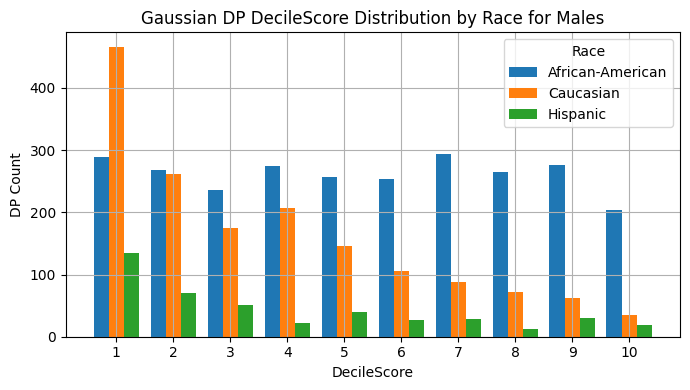

In [266]:
male_dp_gau = table_dp_decile_distribution_by_race(df_top3, 'Male', top3_races,mechanism='gaussian', epsilon=epsilon, delta=delta, seed=200)
print(male_dp_gau)
plot_dp_decile_distribution_by_race_from_table(male_dp_gau, 'Male', top3_races, mechanism_label='Gaussian')

### Gaussian DP – Female

    DecileScore              Race  true_count    dp_count
0             1  African-American          77   86.345422
1             1         Caucasian         137  134.055897
2             1          Hispanic          22   11.963021
3             2  African-American          80   76.119264
4             2         Caucasian          64   72.366526
5             2          Hispanic          20   21.368282
6             3  African-American          61   59.635547
7             3         Caucasian          56   56.910871
8             3          Hispanic          18   19.503943
9             4  African-American          59   63.852995
10            4         Caucasian          41   41.533421
11            4          Hispanic          15   21.374253
12            5  African-American          69   66.428075
13            5         Caucasian          52   51.745234
14            5          Hispanic           2    0.000000
15            6  African-American          55   55.314567
16            

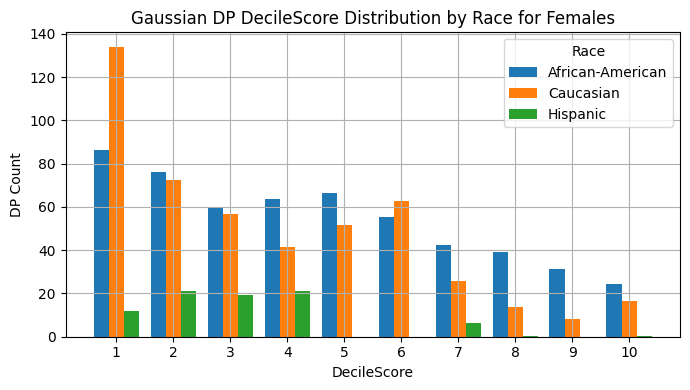

In [267]:
female_dp_gau = table_dp_decile_distribution_by_race(df_top3, 'Female', top3_races,mechanism='gaussian', epsilon=epsilon, delta=delta, seed=201)
print(female_dp_gau)
plot_dp_decile_distribution_by_race_from_table(female_dp_gau, 'Female', top3_races, mechanism_label='Gaussian')

# Query 10: Non-DP Mean DecileScore by Outcome

### Male – Raw Means Table and Plot

   OutcomeTwoYearRecid              Race  mean_decilescore
0                    0  African-American          4.328767
1                    0         Caucasian          2.854489
2                    0          Hispanic          3.018939
3                    1  African-American          6.276406
4                    1         Caucasian          4.679448
5                    1          Hispanic          4.325153


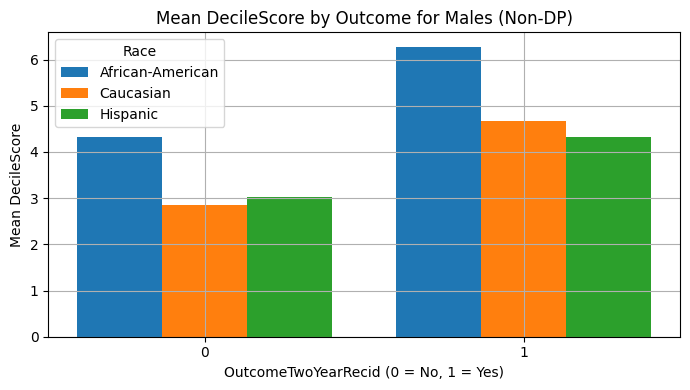

In [268]:
male_means = table_mean_decile_by_outcome_and_race(df_top3, 'Male', top3_races)
print(male_means)
plot_mean_decile_by_outcome_and_race_from_table(male_means, 'Male', top3_races)

### Female – Raw Means Table and Plot

   OutcomeTwoYearRecid              Race  mean_decilescore
0                    0  African-American          3.872832
1                    0         Caucasian          3.214744
2                    0          Hispanic          2.446429
3                    1  African-American          5.945813
4                    1         Caucasian          4.852941
5                    1          Hispanic          3.192308


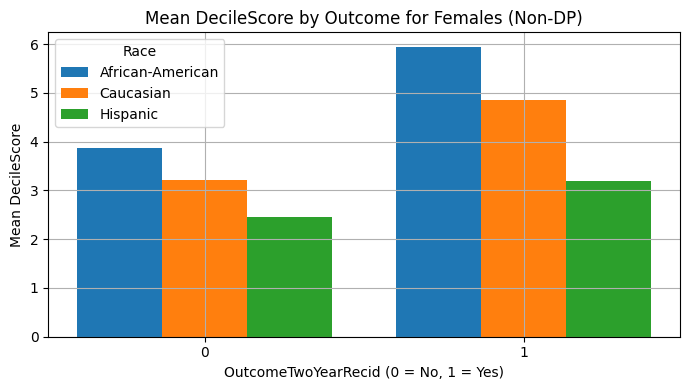

In [269]:
female_means = table_mean_decile_by_outcome_and_race(df_top3, 'Female', top3_races)
print(female_means)
plot_mean_decile_by_outcome_and_race_from_table(female_means, 'Female', top3_races)

# DP Mean DecileScore by Outcome

### Laplace DP – Male

   OutcomeTwoYearRecid              Race  true_mean     n   dp_mean
0                    0  African-American   4.328767  1168  4.331978
1                    0         Caucasian   2.854489   969  2.855675
2                    0          Hispanic   3.018939   264  3.009564
3                    1  African-American   6.276406  1458  6.272171
4                    1         Caucasian   4.679448   652  4.689198
5                    1          Hispanic   4.325153   163  4.385124


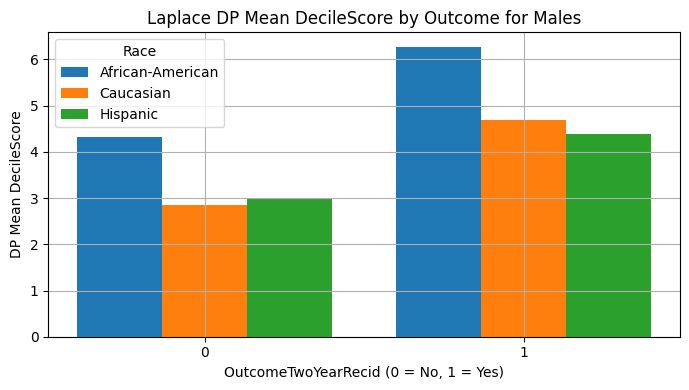

In [270]:
male_dp_mean_lap = table_dp_mean_decile_by_outcome_and_race(df_top3, 'Male', top3_races, mechanism='laplace', epsilon=epsilon, delta=delta, seed=300)
print(male_dp_mean_lap)
plot_dp_mean_decile_by_outcome_and_race_from_table(male_dp_mean_lap, 'Male', top3_races, mechanism_label='Laplace')

### Laplace DP – Female

   OutcomeTwoYearRecid              Race  true_mean    n   dp_mean
0                    0  African-American   3.872832  346  3.867076
1                    0         Caucasian   3.214744  312  3.188353
2                    0          Hispanic   2.446429   56  2.388013
3                    1  African-American   5.945813  203  6.031043
4                    1         Caucasian   4.852941  170  4.930465
5                    1          Hispanic   3.192308   26  3.409649


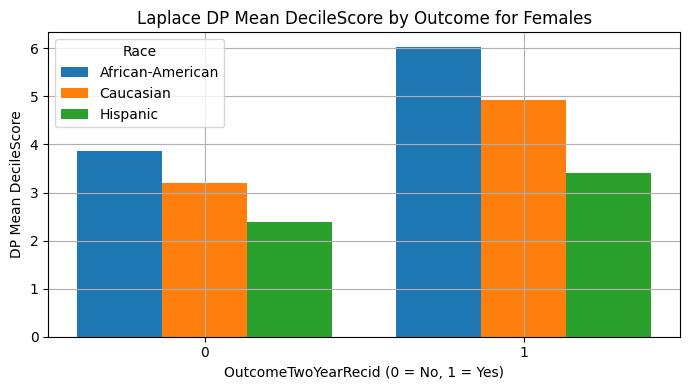

In [271]:
female_dp_mean_lap = table_dp_mean_decile_by_outcome_and_race(df_top3, 'Female', top3_races,mechanism='laplace', epsilon=epsilon, delta=delta, seed=301)
print(female_dp_mean_lap)
plot_dp_mean_decile_by_outcome_and_race_from_table(female_dp_mean_lap, 'Female', top3_races, mechanism_label='Laplace')

### Gaussian DP – Male

   OutcomeTwoYearRecid              Race  true_mean     n   dp_mean
0                    0  African-American   4.328767  1168  4.296133
1                    0         Caucasian   2.854489   969  2.762494
2                    0          Hispanic   3.018939   264  3.296530
3                    1  African-American   6.276406  1458  6.280489
4                    1         Caucasian   4.679448   652  4.596406
5                    1          Hispanic   4.325153   163  4.219035


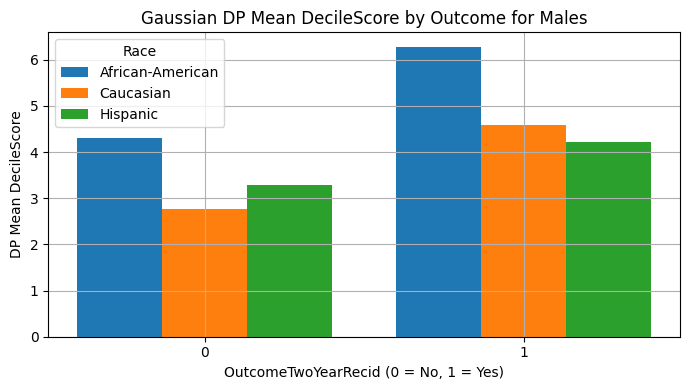

In [272]:
male_dp_mean_gau = table_dp_mean_decile_by_outcome_and_race(df_top3, 'Male', top3_races, mechanism='gaussian', epsilon=epsilon, delta=delta, seed=400)
print(male_dp_mean_gau)
plot_dp_mean_decile_by_outcome_and_race_from_table(male_dp_mean_gau, 'Male', top3_races, mechanism_label='Gaussian')

### Gaussian DP – Female

   OutcomeTwoYearRecid              Race  true_mean    n   dp_mean
0                    0  African-American   3.872832  346  3.766050
1                    0         Caucasian   3.214744  312  3.228812
2                    0          Hispanic   2.446429   56  3.153152
3                    1  African-American   5.945813  203  5.733340
4                    1         Caucasian   4.852941  170  4.734724
5                    1          Hispanic   3.192308   26  0.441092


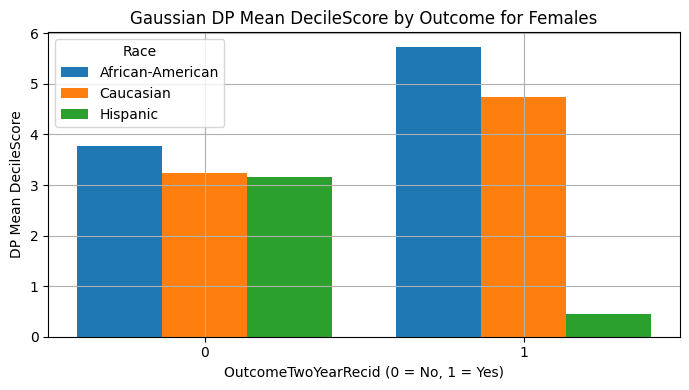

In [273]:
female_dp_mean_gau = table_dp_mean_decile_by_outcome_and_race(df_top3, 'Female', top3_races,mechanism='gaussian', epsilon=epsilon, delta=delta, seed=401)
print(female_dp_mean_gau)
plot_dp_mean_decile_by_outcome_and_race_from_table(female_dp_mean_gau, 'Female', top3_races, mechanism_label='Gaussian')

# Query 11. Epsilon-Sweep Visual Comparison for African-American Group

Now we are going to tune the epsilon values using a range of [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0] with focused on the African-American race to see how the query result changes when compared to the original values. This would help us identify the trade off.

For each ε, we:
- Recompute **Laplace DP** and **Gaussian DP** histograms for Query 8 (DecileScore distribution) and then Plot **side-by-side grouped bar charts** showing Non-DP vs Laplace vs Gaussian.

This visually illustrates how stronger privacy (smaller ε) increases distortion of the underlying histogram for the African-American group.

In [274]:
eps_grid = [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
print('Epsilon grid for sweep:', eps_grid)

Epsilon grid for sweep: [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]


In [275]:
# Select the most common race for focused comparison
selected_race = top3_races[0]
print('Selected race for comparison:', selected_race)

Selected race for comparison: African-American



=== Epsilon = 0.01 ===
   DecileScore  true_count  dp_laplace  dp_gaussian
0            1         288  190.922557   156.785025
1            2         266  229.516511    32.075725
2            3         237  198.902408     0.000000
3            4         278  258.052085     0.000000
4            5         254  221.610077   541.081897
5            6         263  205.985792   364.019500
6            7         293  315.762149   674.068522
7            8         263  225.839029   181.200395
8            9         279  505.690468     0.000000
9           10         205   12.946379   143.167863


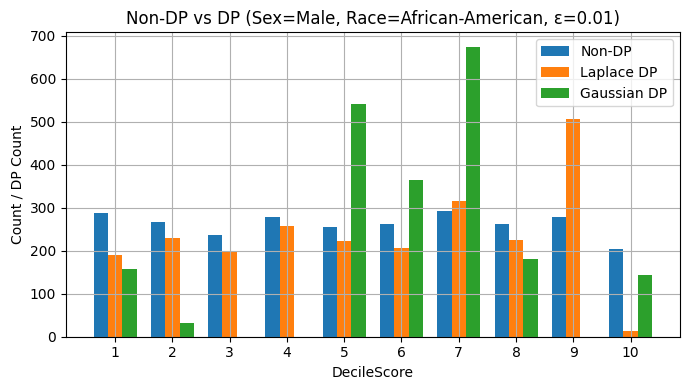


=== Epsilon = 0.1 ===
   DecileScore  true_count  dp_laplace  dp_gaussian
0            1         288  298.486257   310.500565
1            2         266  254.567598   285.709445
2            3         237  231.175085   112.638452
3            4         278  263.960513   308.095188
4            5         254  259.647922   270.796340
5            6         263  267.846081   278.444427
6            7         293  272.698224   260.121862
7            8         263  265.584856   287.137099
8            9         279  294.952159   307.760140
9           10         205  215.252632   166.397243


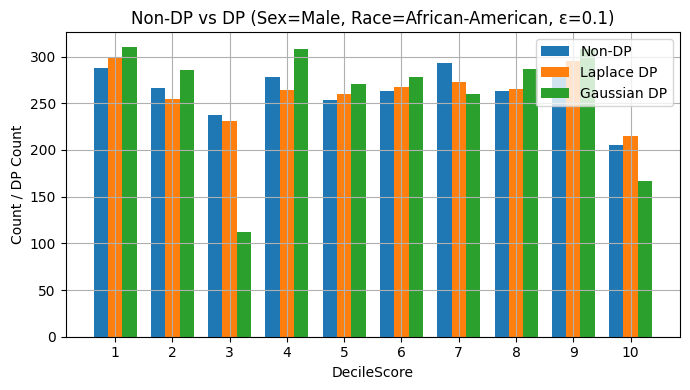


=== Epsilon = 0.2 ===
   DecileScore  true_count  dp_laplace  dp_gaussian
0            1         288  292.181242   299.395799
1            2         266  261.178112   225.301003
2            3         237  236.939648   259.543960
3            4         278  271.800615   270.465743
4            5         254  252.100121   240.650947
5            6         263  243.360419   286.279411
6            7         293  289.134210   309.121586
7            8         263  248.053714   289.445001
8            9         279  278.042745   207.417322
9           10         205  201.148872   181.211355


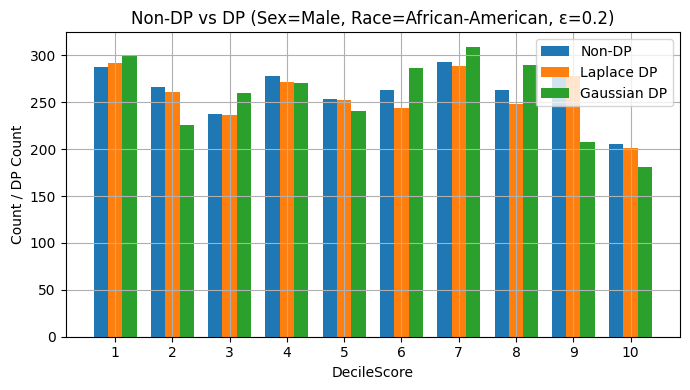


=== Epsilon = 0.3 ===
   DecileScore  true_count  dp_laplace  dp_gaussian
0            1         288  288.751183   289.709061
1            2         266  263.797356   272.963502
2            3         237  233.085773   242.438236
3            4         278  277.121265   256.513801
4            5         254  263.109297   238.596083
5            6         263  268.162139   265.668300
6            7         293  295.664150   314.282382
7            8         263  259.770097   250.284986
8            9         279  277.705878   281.446404
9           10         205  205.880839   227.552351


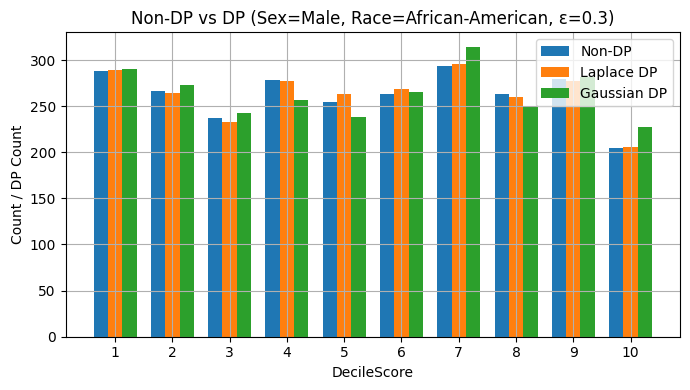


=== Epsilon = 0.5 ===
   DecileScore  true_count  dp_laplace  dp_gaussian
0            1         288  289.874052   281.721514
1            2         266  266.300433   275.554476
2            3         237  243.077749   237.998009
3            4         278  277.604484   283.727961
4            5         254  252.851218   253.831776
5            6         263  260.126488   277.251793
6            7         293  290.831206   287.974239
7            8         263  263.914763   252.186035
8            9         279  278.951137   285.186625
9           10         205  205.296721   219.783947


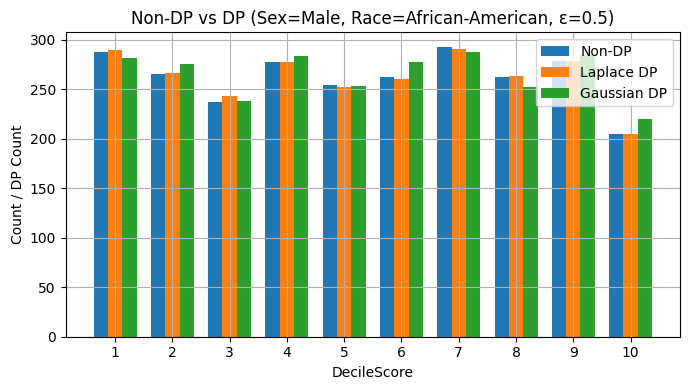


=== Epsilon = 0.7 ===
   DecileScore  true_count  dp_laplace  dp_gaussian
0            1         288  290.644569   288.496555
1            2         266  265.066236   264.066841
2            3         237  237.468816   230.822279
3            4         278  278.911172   271.921003
4            5         254  255.857957   258.366889
5            6         263  263.983101   267.627627
6            7         293  297.296564   289.609014
7            8         263  265.803160   254.084387
8            9         279  277.530996   277.898370
9           10         205  205.833152   213.272855


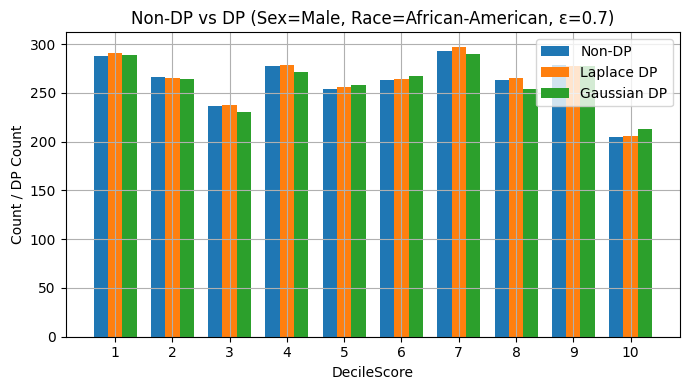


=== Epsilon = 0.8 ===
   DecileScore  true_count  dp_laplace  dp_gaussian
0            1         288  286.659741   299.543157
1            2         266  268.702737   276.376867
2            3         237  236.627480   231.739250
3            4         278  277.953518   273.896579
4            5         254  256.748892   249.242212
5            6         263  257.718682   266.034186
6            7         293  290.300564   295.417848
7            8         263  264.796283   267.127295
8            9         279  279.888123   280.772279
9           10         205  210.212217   212.916846


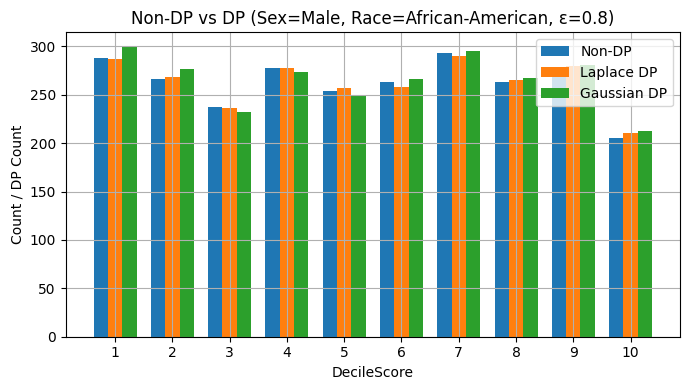


=== Epsilon = 0.9 ===
   DecileScore  true_count  dp_laplace  dp_gaussian
0            1         288  288.296501   287.872050
1            2         266  266.218920   265.279574
2            3         237  235.562912   231.121507
3            4         278  280.679242   278.512076
4            5         254  254.321902   257.825222
5            6         263  261.878873   256.319632
6            7         293  292.880787   298.469374
7            8         263  262.200043   256.219043
8            9         279  280.017528   281.059192
9           10         205  204.684395   201.298471


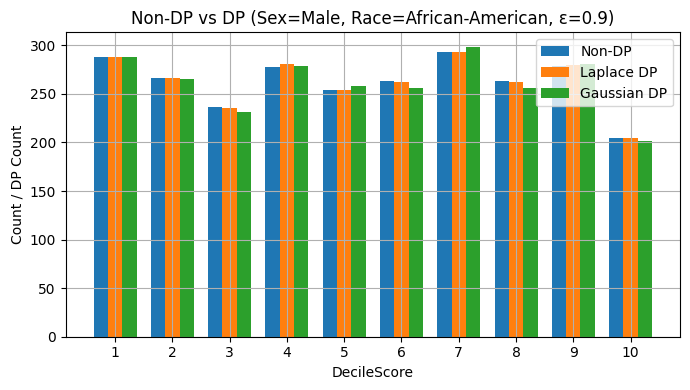


=== Epsilon = 1.0 ===
   DecileScore  true_count  dp_laplace  dp_gaussian
0            1         288  289.166213   271.603657
1            2         266  262.486930   267.998507
2            3         237  239.617404   235.906272
3            4         278  278.319371   283.930520
4            5         254  254.596614   255.299775
5            6         263  264.213236   261.803418
6            7         293  295.015770   285.187532
7            8         263  262.976235   260.927531
8            9         279  277.984518   274.145589
9           10         205  205.295341   202.680291


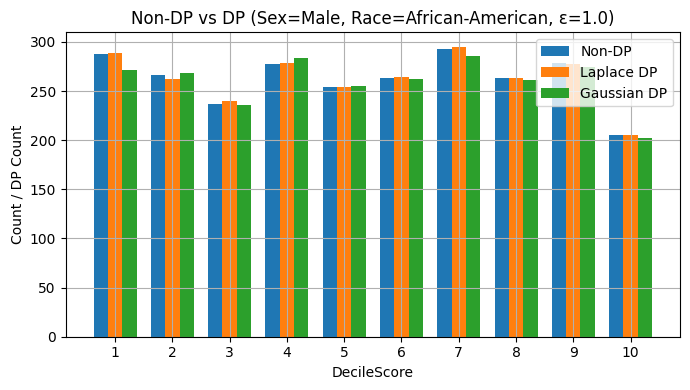

In [276]:
def compare_query1_eps_grid(sex_label='Male', race=None, eps_list=None, delta=delta):
    if race is None:
        race = selected_race
    if eps_list is None:
        eps_list = eps_grid

    subset = df_top3[(df_top3['Sex'] == sex_label) & (df_top3['Race'] == race)].copy()

    # True counts per decile (fixed across eps)
    true_counts = subset.groupby('DecileScore').size()
    true_counts = true_counts.reindex(range(1, 11), fill_value=0)

    for eps in eps_list:
        rng_lap = np.random.default_rng(100000 + int(eps*10000))
        rng_gau = np.random.default_rng(200000 + int(eps*10000))

        dp_lap = []
        dp_gau = []
        for d in range(1, 11):
            c = int(true_counts.loc[d])
            dp_lap.append(dp_count_laplace(c, eps, rng_lap))
            dp_gau.append(dp_count_gaussian(c, eps, delta, rng_gau))

        comp_df = pd.DataFrame({
            'DecileScore': list(range(1, 11)),
            'true_count': true_counts.values,
            'dp_laplace': dp_lap,
            'dp_gaussian': dp_gau,
        })

        print('\n=== Epsilon =', eps, '===')
        print(comp_df)

        # Grouped bar plot: Non-DP vs Laplace vs Gaussian
        x = np.arange(10)
        width = 0.25

        plt.figure()
        plt.bar(x - width, comp_df['true_count'], width, label='Non-DP')
        plt.bar(x, comp_df['dp_laplace'], width, label='Laplace DP')
        plt.bar(x + width, comp_df['dp_gaussian'], width, label='Gaussian DP')

        plt.xticks(x, comp_df['DecileScore'])
        plt.xlabel('DecileScore')
        plt.ylabel('Count / DP Count')
        plt.title(f'Non-DP vs DP (Sex={sex_label}, Race={race}, ε={eps})')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Run the epsilon-sweep comparison for the African-American group
compare_query1_eps_grid(sex_label='Male', race=selected_race, eps_list=eps_grid, delta=delta)

# Query 12. Epsilon-Sweep Visual Comparison for Mean DecileScore

In this section, we extend the epsilon-sweep idea to **Query 9** for the same African-American subgroup.

In [277]:
try:
    eps_grid
except NameError:
    eps_grid = [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
print('Epsilon grid for Query 2 sweep:', eps_grid)

Epsilon grid for Query 2 sweep: [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]



=== Epsilon = 0.01  ===
   OutcomeTwoYearRecid  true_mean     n  dp_laplace  dp_gaussian
0                    0   4.328767  1168    4.292844     2.858948
1                    1   6.276406  1458    6.515083     7.771394


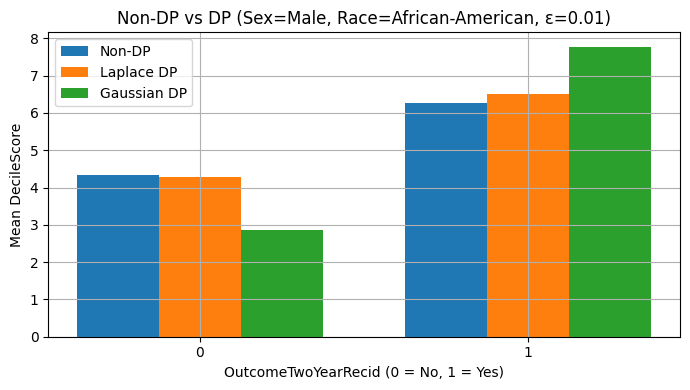


=== Epsilon = 0.1  ===
   OutcomeTwoYearRecid  true_mean     n  dp_laplace  dp_gaussian
0                    0   4.328767  1168    4.571627     4.303062
1                    1   6.276406  1458    6.146305     6.196257


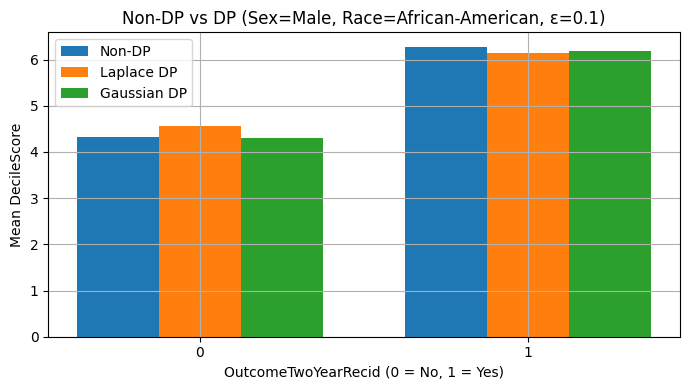


=== Epsilon = 0.2  ===
   OutcomeTwoYearRecid  true_mean     n  dp_laplace  dp_gaussian
0                    0   4.328767  1168    4.338484     4.536942
1                    1   6.276406  1458    6.180720     6.282674


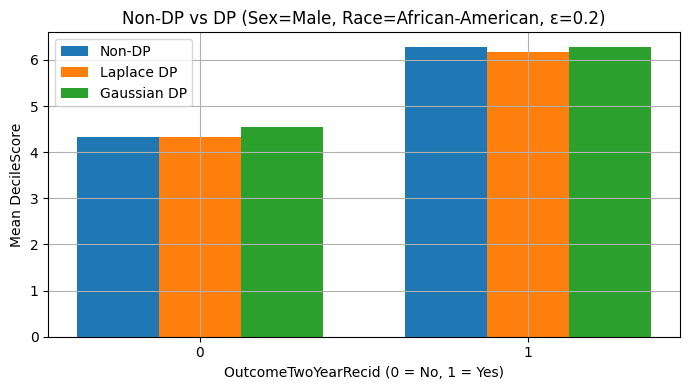


=== Epsilon = 0.3  ===
   OutcomeTwoYearRecid  true_mean     n  dp_laplace  dp_gaussian
0                    0   4.328767  1168    4.335584     4.262927
1                    1   6.276406  1458    6.281311     6.437795


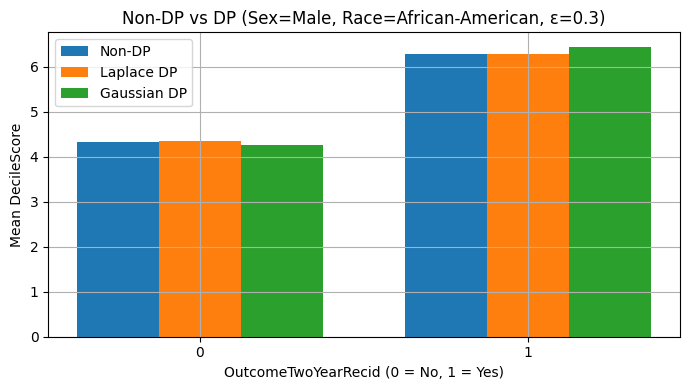


=== Epsilon = 0.5  ===
   OutcomeTwoYearRecid  true_mean     n  dp_laplace  dp_gaussian
0                    0   4.328767  1168    4.334054     4.359803
1                    1   6.276406  1458    6.293005     6.238401


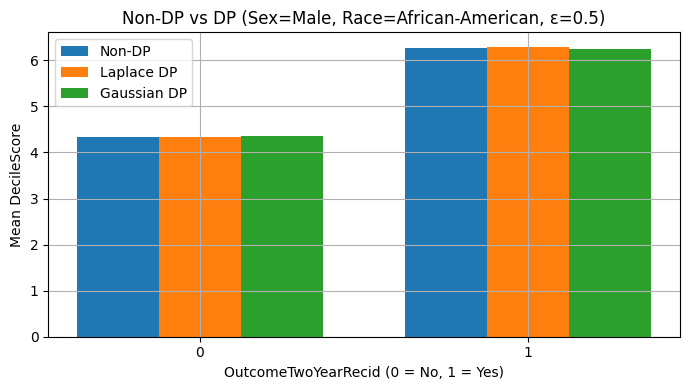


=== Epsilon = 0.7  ===
   OutcomeTwoYearRecid  true_mean     n  dp_laplace  dp_gaussian
0                    0   4.328767  1168    4.329318     4.316601
1                    1   6.276406  1458    6.311656     6.265314


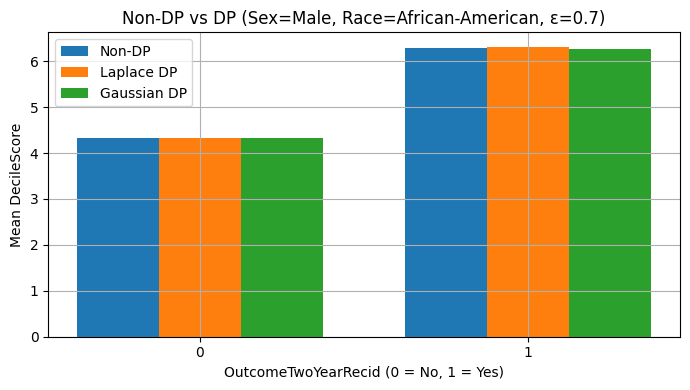


=== Epsilon = 0.8  ===
   OutcomeTwoYearRecid  true_mean     n  dp_laplace  dp_gaussian
0                    0   4.328767  1168    4.328286     4.299249
1                    1   6.276406  1458    6.284047     6.299512


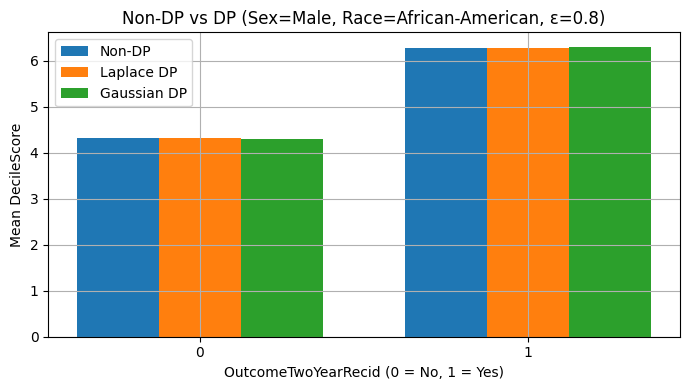


=== Epsilon = 0.9  ===
   OutcomeTwoYearRecid  true_mean     n  dp_laplace  dp_gaussian
0                    0   4.328767  1168    4.327666     4.338020
1                    1   6.276406  1458    6.281569     6.300266


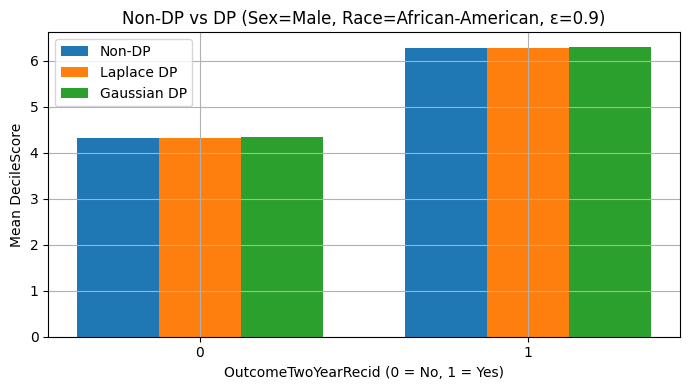


=== Epsilon = 1.0  ===
   OutcomeTwoYearRecid  true_mean     n  dp_laplace  dp_gaussian
0                    0   4.328767  1168    4.319490     4.323287
1                    1   6.276406  1458    6.263179     6.249003


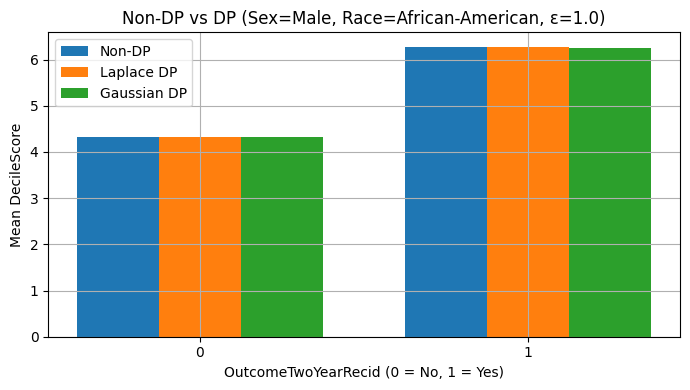

In [278]:
def compare_query2_eps_grid(sex_label='Male', race=None, eps_list=None, delta=delta):
    if race is None:
        race = selected_race
    if eps_list is None:
        eps_list = eps_grid

    subset = df_top3[(df_top3['Sex'] == sex_label) & (df_top3['Race'] == race)].copy()

    # True stats by outcome (fixed across eps)
    stats = subset.groupby('OutcomeTwoYearRecid')['DecileScore'].agg(['mean', 'count']).reset_index()

    for eps in eps_list:
        rng_lap = np.random.default_rng(300000 + int(eps*10000))
        rng_gau = np.random.default_rng(400000 + int(eps*10000))

        outcomes = []
        true_means = []
        ns = []
        dp_lap = []
        dp_gau = []

        for _, row in stats.iterrows():
            o = int(row['OutcomeTwoYearRecid'])
            m = row['mean']
            n = int(row['count'])
            outcomes.append(o)
            true_means.append(m)
            ns.append(n)
            dp_lap.append(dp_mean_laplace(m, n, eps, rng_lap))
            dp_gau.append(dp_mean_gaussian(m, n, eps, delta, rng_gau))

        comp_df = pd.DataFrame({
            'OutcomeTwoYearRecid': outcomes,
            'true_mean': true_means,
            'n': ns,
            'dp_laplace': dp_lap,
            'dp_gaussian': dp_gau,
        })

        print('\n=== Epsilon =', eps, ' ===')
        print(comp_df)

        x = np.arange(len(outcomes))
        width = 0.25

        plt.figure()
        plt.bar(x - width, comp_df['true_mean'], width, label='Non-DP')
        plt.bar(x, comp_df['dp_laplace'], width, label='Laplace DP')
        plt.bar(x + width, comp_df['dp_gaussian'], width, label='Gaussian DP')

        plt.xticks(x, comp_df['OutcomeTwoYearRecid'])
        plt.xlabel('OutcomeTwoYearRecid (0 = No, 1 = Yes)')
        plt.ylabel('Mean DecileScore')
        plt.title(f'Non-DP vs DP (Sex={sex_label}, Race={race}, ε={eps})')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Run the epsilon-sweep comparison for the African-American group
compare_query2_eps_grid(sex_label='Male', race=selected_race, eps_list=eps_grid, delta=delta)

# Privacy–Utility Analysis

In [279]:
true_means_full = (
    df_top3
    .groupby(['Race', 'Sex', 'OutcomeTwoYearRecid'])['DecileScore']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'true_mean', 'count': 'n'})
)
print(true_means_full.head())

eps_values = [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]
delta = 1e-5
num_runs = 50

               Race     Sex  OutcomeTwoYearRecid  true_mean     n
0  African-American  Female                    0   3.872832   346
1  African-American  Female                    1   5.945813   203
2  African-American    Male                    0   4.328767  1168
3  African-American    Male                    1   6.276406  1458
4         Caucasian  Female                    0   3.214744   312


# Query 13: Privacy–Utility Trade-Off (Laplace vs Gaussian)

Laplace MAE: [np.float64(5.766241459922747), np.float64(0.5766241459922747), np.float64(0.2883120729961373), np.float64(0.19220804866409158), np.float64(0.11532482919845495), np.float64(0.0823748779988964), np.float64(0.07207801824903434), np.float64(0.06406934955469719), np.float64(0.05766241459922748)]
Gaussian MAE: [np.float64(26.14235052199486), np.float64(2.6142350521994855), np.float64(1.307117526099743), np.float64(0.8714116840664955), np.float64(0.5228470104398972), np.float64(0.3734621503142123), np.float64(0.32677938152493574), np.float64(0.2904705613554985), np.float64(0.2614235052199486)]


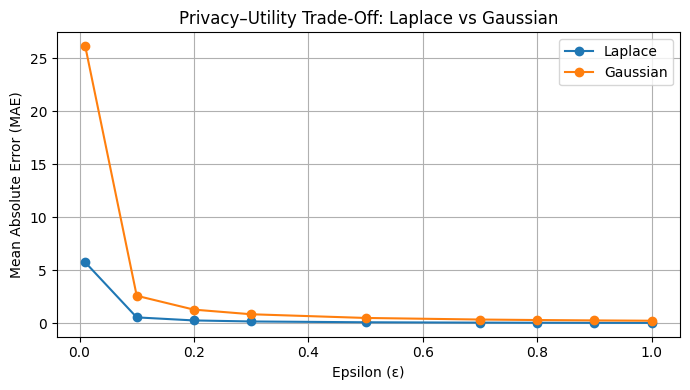

In [ ]:
laplace_mae = []
gaussian_mae = []

for eps in eps_values:
    lap_err = []
    gau_err = []
    for run in range(num_runs):
        rng_lap = np.random.default_rng(1000 + run)
        rng_gau = np.random.default_rng(2000 + run)
        for _, row in true_means_full.iterrows():
            t = row['true_mean']
            n = int(row['n'])
            lap = dp_mean_laplace(t, n, eps, rng_lap)
            gau = dp_mean_gaussian(t, n, eps, delta, rng_gau)
            lap_err.append(abs(lap - t))
            gau_err.append(abs(gau - t))
    laplace_mae.append(np.mean(lap_err))
    gaussian_mae.append(np.mean(gau_err))

print('Laplace MAE:', laplace_mae)
print('Gaussian MAE:', gaussian_mae)

plt.figure()
plt.plot(eps_values, laplace_mae, marker='o', label='Laplace')
plt.plot(eps_values, gaussian_mae, marker='o', label='Gaussian')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Privacy Utility Trade-Off: Laplace vs Gaussian')
plt.legend()
plt.tight_layout()
plt.show()